<a href="https://colab.research.google.com/github/casjunior93/projeto-integrador-iv/blob/main/Etl_e_cria%C3%A7%C3%A3o_dos_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas fundamentais

In [108]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import scipy.stats as stats
import urllib.request, json 
from pandas.io.json import json_normalize

#Scikit-Learn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#Configura o pandas para não exibir resultados em notação científica
pd.options.display.float_format = '{:.2f}'.format

#Semente aleatória do Numpy
np.random.seed(42)

#Data local
import locale
# Colab não suporta
#locale.setlocale(locale.LC_ALL, 'pt_BR.utf8')

# URL base da api de dados

In [2]:
url_base = 'https://univesp-analytics.vercel.app/api/get'

# Lendo Json com Pandas

In [3]:
%%time
pagina = 1
limite = 10000
fim_iteracao_api = False
df_dados_api_original = pd.DataFrame([])

print(f'Início das requisições')
while fim_iteracao_api == False:
  with urllib.request.urlopen(url_base + '?page=' + str(pagina) + '&limite=' + str(limite)) as url:
    data = json.loads(url.read().decode())
    df = pd.DataFrame(json_normalize(data))
    print('.', end='')
    if len(data) == 0:
      print('')
      print(f'Fim. Total de {pagina - 1} páginas e {df_dados_api_original.shape[0]} registros.')
      fim_iteracao_api = True
    else:
      if pagina % 100 == 0:
        print(f'Fim leitura página {pagina}')
      pagina += 1
      df_dados_api_original = pd.concat([df_dados_api_original, df], ignore_index = True)

Início das requisições
.........
Fim. Total de 8 páginas e 79430 registros.
CPU times: user 1.84 s, sys: 93.8 ms, total: 1.94 s
Wall time: 19.5 s


In [4]:
%%time
''' with urllib.request.urlopen(url_base + '?page=' + str(pagina) + '&limite=' + str(limite)) as url:
    data = json.loads(url.read().decode())
    df_dados_api_original = pd.DataFrame(json_normalize(data)) '''

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


" with urllib.request.urlopen(url_base + '?page=' + str(pagina) + '&limite=' + str(limite)) as url:\n    data = json.loads(url.read().decode())\n    df_dados_api_original = pd.DataFrame(json_normalize(data)) "

Cópia dos dados da api

In [5]:
df_dados_api = df_dados_api_original.copy()

Dimensão dos dados - Linhas, colunas

In [6]:
df_dados_api.shape

(79430, 9)

# Visualizando dados originais

Mudando ordenação dos dados

In [7]:
df_dados_api.sort_index(ascending=False, inplace=True, ignore_index=True)

Cinco primeiros registros do dataframe - Em ordem da disposição na API

In [8]:
df_dados_api.head()

,_id,temp_ar,umid_ar,type,local,time.time_js,time.data,time.hora,teste
0,63fea0720dd58484fc266c80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.00
1,63ffdbb91a4eb0dfdd6a11a7,2,3,teste,NaN,2023-03-01T23:11:53.036Z,01/03/2023,20:11:53,NaN
2,63ffdbde1a4eb0dfdd6a11a8,10,10,teste,NaN,2023-03-01T23:12:30.063Z,01/03/2023,20:12:30,NaN
3,63ffdea6722bef68acc5bb72,333,333,teste,NaN,2023-03-01T23:24:21.438Z,01/03/2023,23:24:21,NaN
4,63ffed2b38c8784e07b788f2,15,15,teste,NaN,01/03/2023 21:26:19,01/03/2023,21:26:19,NaN


Cinco últimos registros do dataframe

In [9]:
df_dados_api.tail()

,_id,temp_ar,umid_ar,type,local,time.time_js,time.data,time.hora,teste
79425,644d316420d77f53d37e81db,22.50,71.80,teste,semAr,"29/04/2023, 12:01:56","29/04/2023,",12:01:56,NaN
79426,644d324f20d77f53d37e81dc,24.80,60.00,teste,comAr,"29/04/2023, 12:05:51","29/04/2023,",12:05:51,NaN
79427,644d329220d77f53d37e81dd,22.50,71.40,teste,semAr,"29/04/2023, 12:06:58","29/04/2023,",12:06:58,NaN
79428,644d337e20d77f53d37e81de,24.80,59.80,teste,comAr,"29/04/2023, 12:10:54","29/04/2023,",12:10:54,NaN
79429,644d33c020d77f53d37e81df,22.60,71.30,teste,semAr,"29/04/2023, 12:12:00","29/04/2023,",12:12:00,NaN


Verificando dados nulos

In [10]:
df_dados_api.isnull().sum()

_id                 0
temp_ar             3
umid_ar             3
type                1
local           55412
time.time_js        1
time.data           1
time.hora           1
teste           79429
dtype: int64

Excluindo colunas desnecessárias

In [11]:
del df_dados_api['teste']
del df_dados_api['_id']
del df_dados_api['type']
del df_dados_api['time.time_js']
df_dados_api.head()

,temp_ar,umid_ar,local,time.data,time.hora
0,NaN,NaN,NaN,NaN,NaN
1,2,3,NaN,01/03/2023,20:11:53
2,10,10,NaN,01/03/2023,20:12:30
3,333,333,NaN,01/03/2023,23:24:21
4,15,15,NaN,01/03/2023,21:26:19


Tratando nova coluna local

In [12]:
df_dados_api.local.value_counts()

semAr    20554
comAr     3460
API          2
teste        1
123          1
Name: local, dtype: int64

In [13]:
values = {"local": "comAr"}
df_dados_api.fillna(value=values, inplace=True)

In [14]:
df_dados_api.local.value_counts()

comAr    58872
semAr    20554
API          2
teste        1
123          1
Name: local, dtype: int64

Limpeza de dados nulos

In [15]:
df_dados_api.dropna(inplace = True)
df_dados_api.isnull().sum()

temp_ar      0
umid_ar      0
local        0
time.data    0
time.hora    0
dtype: int64

Removendo dados duplicados

In [16]:
df_dados_api.shape

(79427, 5)

In [17]:
df_dados_api.drop_duplicates(inplace=True, ignore_index=True)
df_dados_api.shape

(79427, 5)

# Comportamento das variáveis

Tipo dos dados e convertendo strings para float

In [18]:
df_dados_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79427 entries, 0 to 79426
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   temp_ar    79427 non-null  object
 1   umid_ar    79427 non-null  object
 2   local      79427 non-null  object
 3   time.data  79427 non-null  object
 4   time.hora  79427 non-null  object
dtypes: object(5)
memory usage: 3.0+ MB


In [19]:
df_dados_api = df_dados_api.astype({'temp_ar':'float', 'umid_ar':'float'})
df_dados_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79427 entries, 0 to 79426
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   temp_ar    79427 non-null  float64
 1   umid_ar    79427 non-null  float64
 2   local      79427 non-null  object 
 3   time.data  79427 non-null  object 
 4   time.hora  79427 non-null  object 
dtypes: float64(2), object(3)
memory usage: 3.0+ MB


Análise descritiva dos dados

In [20]:
df_dados_api.describe()

,temp_ar,umid_ar
count,79427.00,79427.00
mean,25.66,59.67
std,2.63,8.44
min,2.00,3.00
25%,25.30,54.00
50%,26.00,58.00
75%,26.50,64.00
max,333.00,333.00


Opa, parece haver outliers.

Separando os conjuntos de dados do ambiente com ar condicionado e sem ar condicionado.

In [21]:
df_comAr = df_dados_api.loc[df_dados_api['local'] == 'comAr']
df_semAr = df_dados_api.loc[df_dados_api['local'] == 'semAr']

Verificando outliers

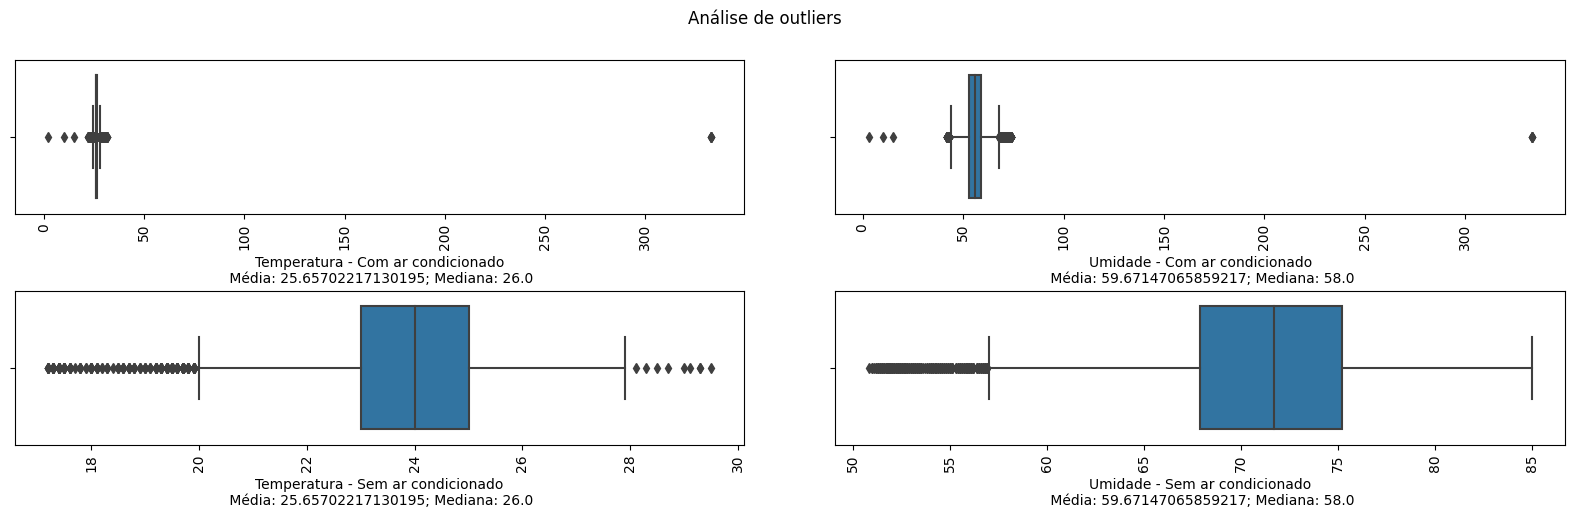

CPU times: user 718 ms, sys: 88.5 ms, total: 807 ms
Wall time: 780 ms


In [22]:
%%time
fig, axes = plt.subplots(2, 2, figsize = (20,5))
fig.subplots_adjust(hspace=0.5, wspace=0.125)
fig.suptitle('Análise de outliers')

#Temperatura Com ar condicionado - Boxplot
sns.boxplot(ax=axes[0,0],x=df_comAr['temp_ar'])
axes[0,0].tick_params(axis='x', rotation=90)
axes[0,0].set(xlabel='Temperatura - Com ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade Com ar condicionado - Boxplot
sns.boxplot(ax=axes[0,1],x=df_comAr['umid_ar'])
axes[0,1].tick_params(axis='x', rotation=90)
axes[0,1].set(xlabel='Umidade - Com ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

#Temperatura Com ar condicionado - Boxplot
sns.boxplot(ax=axes[1,0],x=df_semAr['temp_ar'])
axes[1,0].tick_params(axis='x', rotation=90)
axes[1,0].set(xlabel='Temperatura - Sem ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade Com ar condicionado - Boxplot
sns.boxplot(ax=axes[1,1],x=df_semAr['umid_ar'])
axes[1,1].tick_params(axis='x', rotation=90)
axes[1,1].set(xlabel='Umidade - Sem ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

plt.show();

Excluindo outliers superiores do conjunto com ar condicionado

In [23]:
def limites_outliers(coluna):
  Q1 = coluna.quantile(.25)
  Q3 = coluna.quantile(.75)
  IIQ = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IIQ
  limite_superior = Q3 + 1.5 * IIQ
  return limite_inferior, limite_superior

In [24]:
limite_inferior_temp_ar, limite_superior_temp_ar = limites_outliers(df_comAr['temp_ar'])
limite_inferior_umid_ar, limite_superior_umid_ar = limites_outliers(df_comAr['umid_ar'])

Visualizando registros considerados como outliers

In [25]:
selecao_temp_ar = (df_comAr['temp_ar'] > limite_superior_temp_ar) | (df_comAr['umid_ar'] > limite_superior_umid_ar)
temp_ar1 = df_comAr[selecao_temp_ar]
temp_ar1.describe()

,temp_ar,umid_ar
count,2122.00,2122.00
mean,28.21,54.54
std,13.34,14.87
min,21.90,43.00
25%,28.00,48.00
50%,28.20,50.00
75%,28.40,55.00
max,333.00,333.00


In [26]:
selecao_temp_ar2 = (temp_ar1['temp_ar'] < 333.0) | (temp_ar1['umid_ar'] < 333.0)
temp_ar2 = temp_ar1[selecao_temp_ar2]
temp_ar2.describe()

,temp_ar,umid_ar
count,2118.00,2118.00
mean,27.63,54.01
std,1.55,8.65
min,21.90,43.00
25%,28.00,48.00
50%,28.20,50.00
75%,28.40,55.00
max,31.20,74.00


Removendo dados com valor de temp_ar e umid_ar iguais à 333,0. Não vou remover valores menores que este porque são valores possíveis de acontecer.

In [27]:
selecao_temp_ar = (df_comAr['temp_ar'] <= 31.20) & (df_comAr['umid_ar'] <= 74)
df_comAr = df_comAr[selecao_temp_ar]

Revendo boxplots

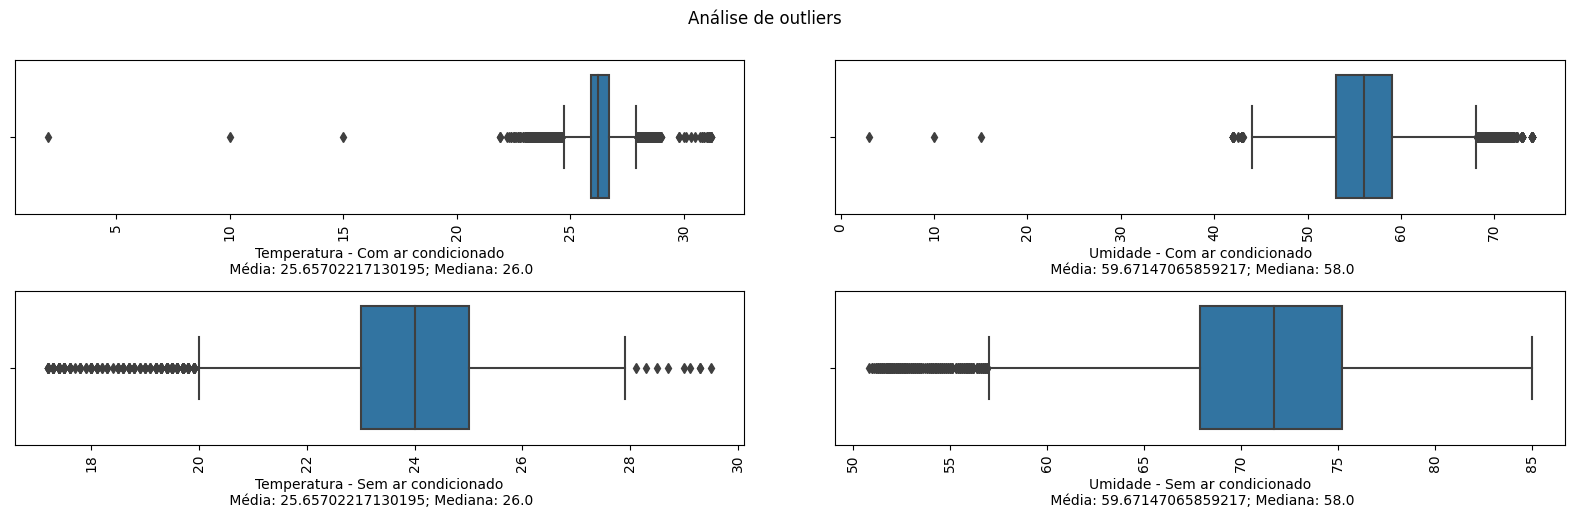

In [28]:
fig, axes = plt.subplots(2, 2, figsize = (20,5))
fig.subplots_adjust(hspace=0.5, wspace=0.125)
fig.suptitle('Análise de outliers')

#Temperatura Com ar condicionado - Boxplot
sns.boxplot(ax=axes[0,0],x=df_comAr['temp_ar'])
axes[0,0].tick_params(axis='x', rotation=90)
axes[0,0].set(xlabel='Temperatura - Com ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade Com ar condicionado - Boxplot
sns.boxplot(ax=axes[0,1],x=df_comAr['umid_ar'])
axes[0,1].tick_params(axis='x', rotation=90)
axes[0,1].set(xlabel='Umidade - Com ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

#Temperatura Com ar condicionado - Boxplot
sns.boxplot(ax=axes[1,0],x=df_semAr['temp_ar'])
axes[1,0].tick_params(axis='x', rotation=90)
axes[1,0].set(xlabel='Temperatura - Sem ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade Com ar condicionado - Boxplot
sns.boxplot(ax=axes[1,1],x=df_semAr['umid_ar'])
axes[1,1].tick_params(axis='x', rotation=90)
axes[1,1].set(xlabel='Umidade - Sem ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

plt.show();

Agora as curvas de densidade das variáveis

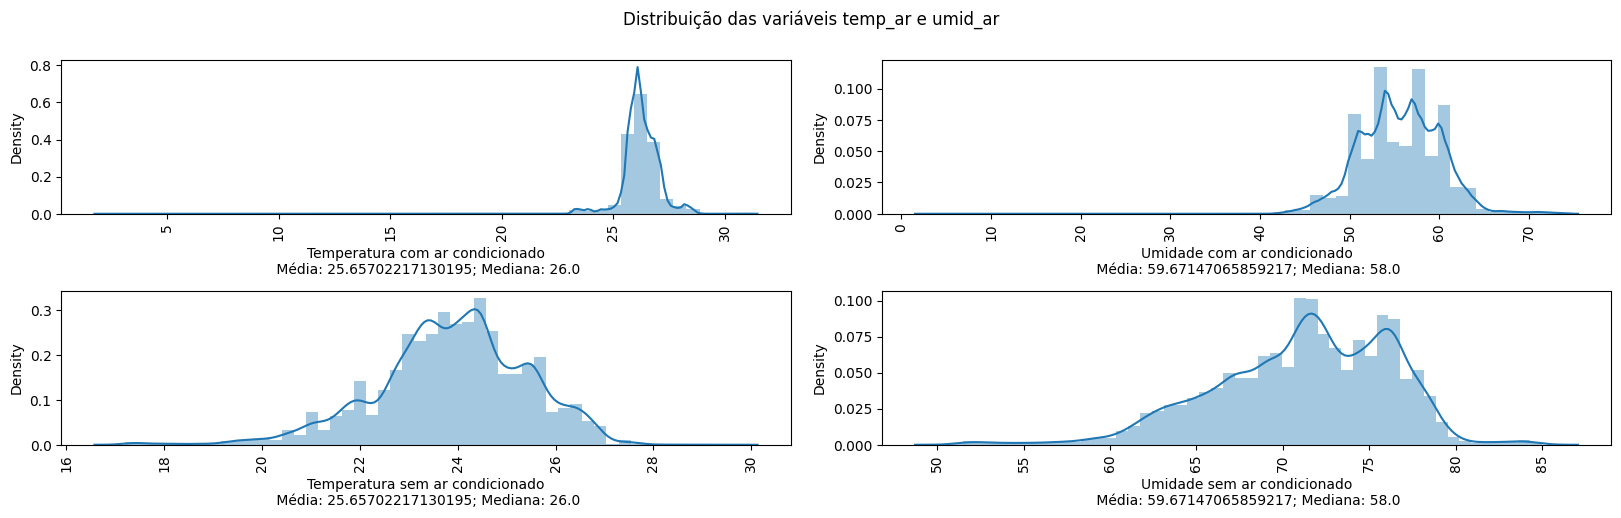

CPU times: user 2.46 s, sys: 394 ms, total: 2.86 s
Wall time: 2.68 s


In [29]:
%%time
fig, axes = plt.subplots(2, 2, figsize = (20,5))
fig.subplots_adjust(hspace=0.5, wspace=0.125)
fig.suptitle('Distribuição das variáveis temp_ar e umid_ar')

#Temperatura - distplot
sns.distplot(ax=axes[0,0],x=df_comAr['temp_ar'])
axes[0,0].tick_params(axis='x', rotation=90)
axes[0,0].set(xlabel='Temperatura com ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade - distplot
sns.distplot(ax=axes[0,1],x=df_comAr['umid_ar'])
axes[0,1].tick_params(axis='x', rotation=90)
axes[0,1].set(xlabel='Umidade com ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

#Temperatura - distplot
sns.distplot(ax=axes[1,0],x=df_semAr['temp_ar'])
axes[1,0].tick_params(axis='x', rotation=90)
axes[1,0].set(xlabel='Temperatura sem ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade - distplot
sns.distplot(ax=axes[1,1],x=df_semAr['umid_ar'])
axes[1,1].tick_params(axis='x', rotation=90)
axes[1,1].set(xlabel='Umidade sem ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

plt.show();

Testando se as distruições são normais

In [30]:
%%time
stat_temp_comar,p_temp_comarar = stats.shapiro(df_comAr['temp_ar'].to_numpy())
stat_umid_comarar,p_umid_comarar = stats.shapiro(df_comAr['umid_ar'].to_numpy())

stat_temp_semar,p_temp_semar = stats.shapiro(df_semAr['temp_ar'].to_numpy())
stat_umid_semar,p_umid_semar = stats.shapiro(df_semAr['umid_ar'].to_numpy())

CPU times: user 12 ms, sys: 1 µs, total: 12 ms
Wall time: 12.8 ms


In [31]:
print(f'p-value temp_ar com ar condicionado: {p_temp_comarar:.5f}')
print(f'p-value umid_ar com ar condicionado: {p_umid_comarar:.5f}')
print(f'p-value temp_ar sem ar condicionado: {p_temp_semar:.5f}')
print(f'p-value umid_ar sem ar condicionado: {p_umid_semar:.5f}')

p-value temp_ar com ar condicionado: 0.00000
p-value umid_ar com ar condicionado: 0.00000
p-value temp_ar sem ar condicionado: 0.00000
p-value umid_ar sem ar condicionado: 0.00000


Com os p_values < 0.5, logo curvas não normais.

# Tratando data

Copiando dataframes para uma nova variável

In [32]:
dados_projeto_comar = df_comAr.copy()
dados_projeto_semar = df_semAr.copy()

Removendo virgula de time.data e concatenando com time.hora para gerar data no formato datetime

In [33]:
def converte_data_portugues_para_ingles(df):
  return datetime.strptime(df['time.data'], "%d/%m/%Y").strftime("%Y-%m-%d");

In [34]:
dados_projeto_comar['time.data'] = dados_projeto_comar['time.data'].str.replace(',','')
dados_projeto_comar['time.data'] = dados_projeto_comar.apply(lambda x: converte_data_portugues_para_ingles(x), axis=1)
dados_projeto_comar['data'] = dados_projeto_comar['time.data'] + ' ' + dados_projeto_comar['time.hora']
dados_projeto_comar['data'] = dados_projeto_comar['data'].astype('datetime64[ns]')

dados_projeto_semar['time.data'] = dados_projeto_semar['time.data'].str.replace(',','')
dados_projeto_semar['time.data'] = dados_projeto_semar.apply(lambda x: converte_data_portugues_para_ingles(x), axis=1)
dados_projeto_semar['data'] = dados_projeto_semar['time.data'] + ' ' + dados_projeto_semar['time.hora']
dados_projeto_semar['data'] = dados_projeto_semar['data'].astype('datetime64[ns]')

In [35]:
dados_projeto_semar.tail()

,temp_ar,umid_ar,local,time.data,time.hora,data
79418,22.50,71.60,semAr,2023-04-29,11:51:52,2023-04-29 11:51:52
79420,22.50,71.50,semAr,2023-04-29,11:56:54,2023-04-29 11:56:54
79422,22.50,71.80,semAr,2023-04-29,12:01:56,2023-04-29 12:01:56
79424,22.50,71.40,semAr,2023-04-29,12:06:58,2023-04-29 12:06:58
79426,22.60,71.30,semAr,2023-04-29,12:12:00,2023-04-29 12:12:00


Verificando nulos novamente

In [36]:
dados_projeto_semar.isnull().sum()

temp_ar      0
umid_ar      0
local        0
time.data    0
time.hora    0
data         0
dtype: int64

In [37]:
dados_projeto_comar.isnull().sum()

temp_ar      0
umid_ar      0
local        0
time.data    0
time.hora    0
data         0
dtype: int64

Deletando colunas que não vamos usar mais

In [38]:
del dados_projeto_semar['time.data']
del dados_projeto_semar['time.hora']
del dados_projeto_semar['local']

del dados_projeto_comar['time.data']
del dados_projeto_comar['time.hora']
del dados_projeto_comar['local']

# Filtro por período a partir do dia 04/03/2023

In [39]:
filtro = (dados_projeto_comar.data >= '2023-03-04 00:00:00') & (dados_projeto_comar.data < '2023-04-29 00:00:00')
serie_comar = dados_projeto_comar.loc[filtro]
serie_comar.describe()

,temp_ar,umid_ar
count,58219.00,58219.00
mean,26.25,55.64
std,0.78,4.39
min,21.90,42.00
25%,25.90,53.00
50%,26.20,56.00
75%,26.70,59.00
max,29.00,74.00


In [40]:
filtro2 = (dados_projeto_semar.data >= '2023-03-04 00:00:00') & (dados_projeto_semar.data <= '2023-04-26 00:00:00')
serie_semar = dados_projeto_semar.loc[filtro2]
serie_semar.describe()

,temp_ar,umid_ar
count,19558.00,19558.00
mean,23.97,71.11
std,1.50,5.07
min,17.20,50.80
25%,23.10,67.80
50%,24.00,71.60
75%,25.00,75.10
max,29.50,85.00


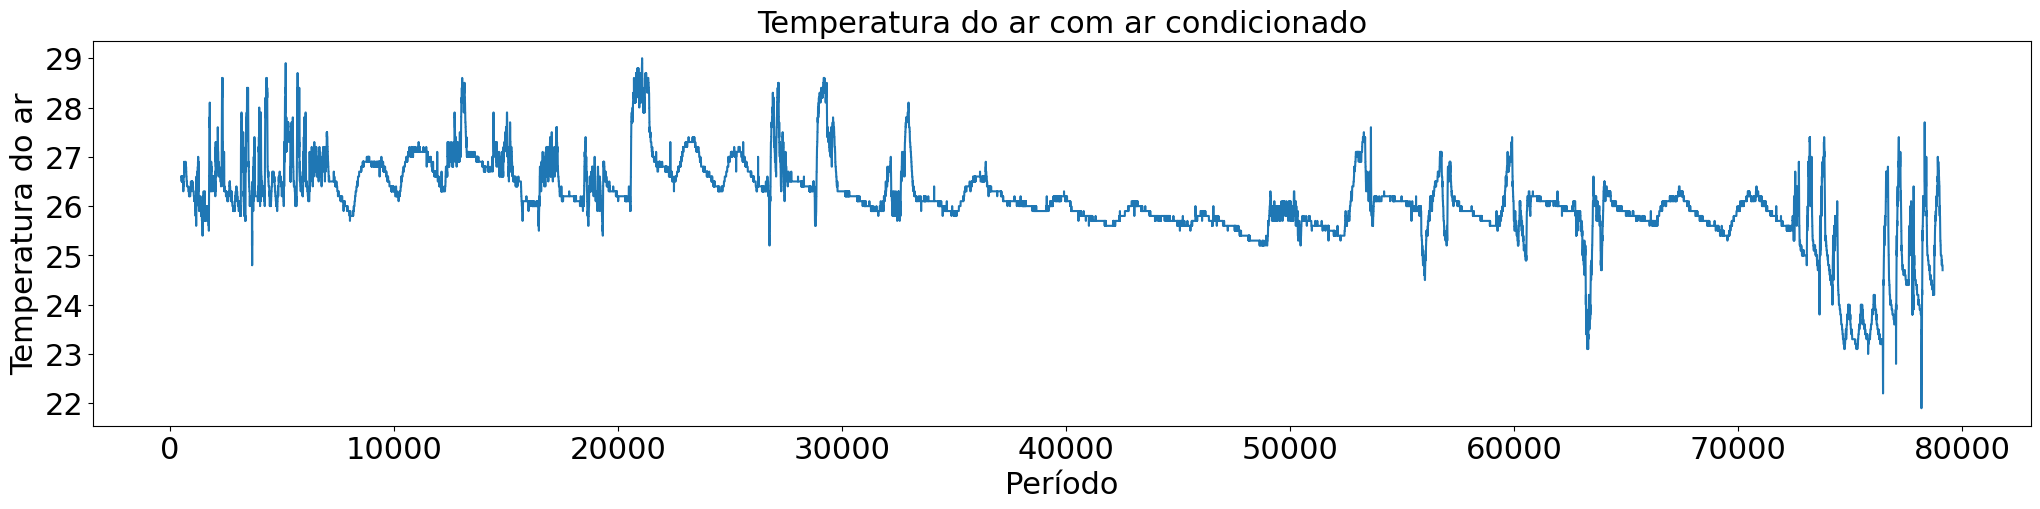

CPU times: user 597 ms, sys: 119 ms, total: 716 ms
Wall time: 610 ms


In [41]:
%%time
plt.figure(figsize=(25,5))
serie_comar.temp_ar.plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('Temperatura do ar',size=22)
plt.title('Temperatura do ar com ar condicionado',size=22)

plt.savefig('data_temp_ar_conjunto_tratado_original.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

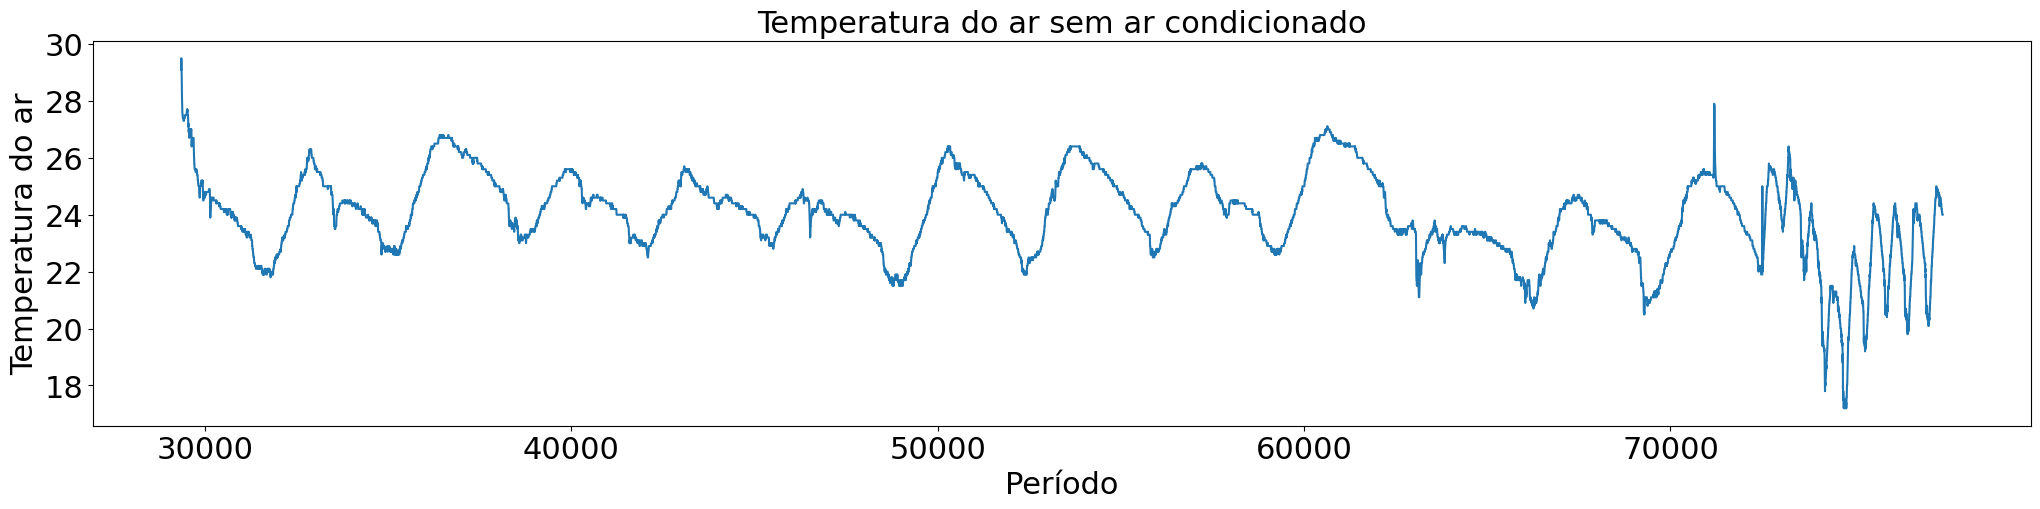

CPU times: user 504 ms, sys: 104 ms, total: 608 ms
Wall time: 508 ms


In [42]:
%%time
plt.figure(figsize=(25,5))
serie_semar.temp_ar.plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('Temperatura do ar',size=22)
plt.title('Temperatura do ar sem ar condicionado',size=22)

plt.savefig('data_temp_ar_conjunto_tratado_original_sem_ar.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

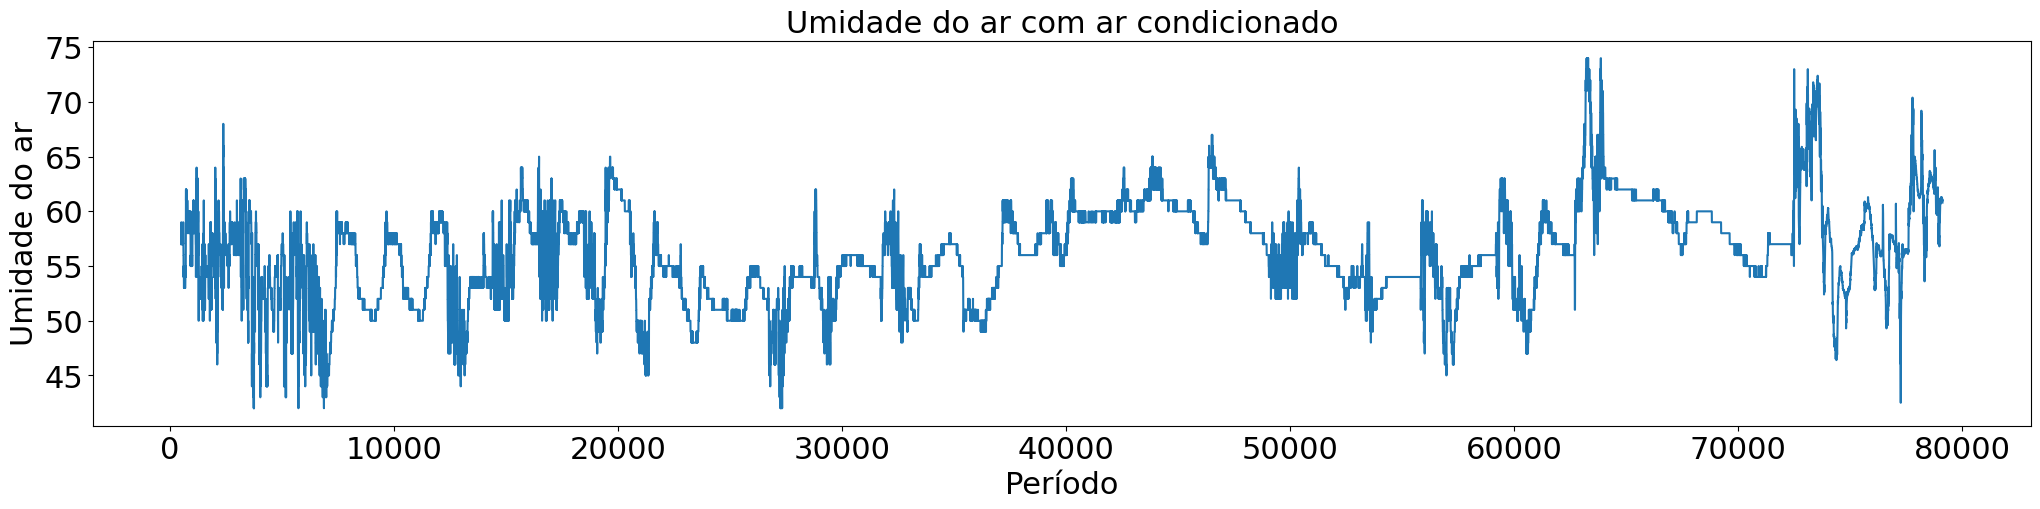

CPU times: user 612 ms, sys: 124 ms, total: 736 ms
Wall time: 615 ms


In [43]:
%%time
plt.figure(figsize=(25,5))
serie_comar.umid_ar.plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('Umidade do ar',size=22)
plt.title('Umidade do ar com ar condicionado',size=22)

plt.savefig('data_umidade_ar_conjunto_tratado_original.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

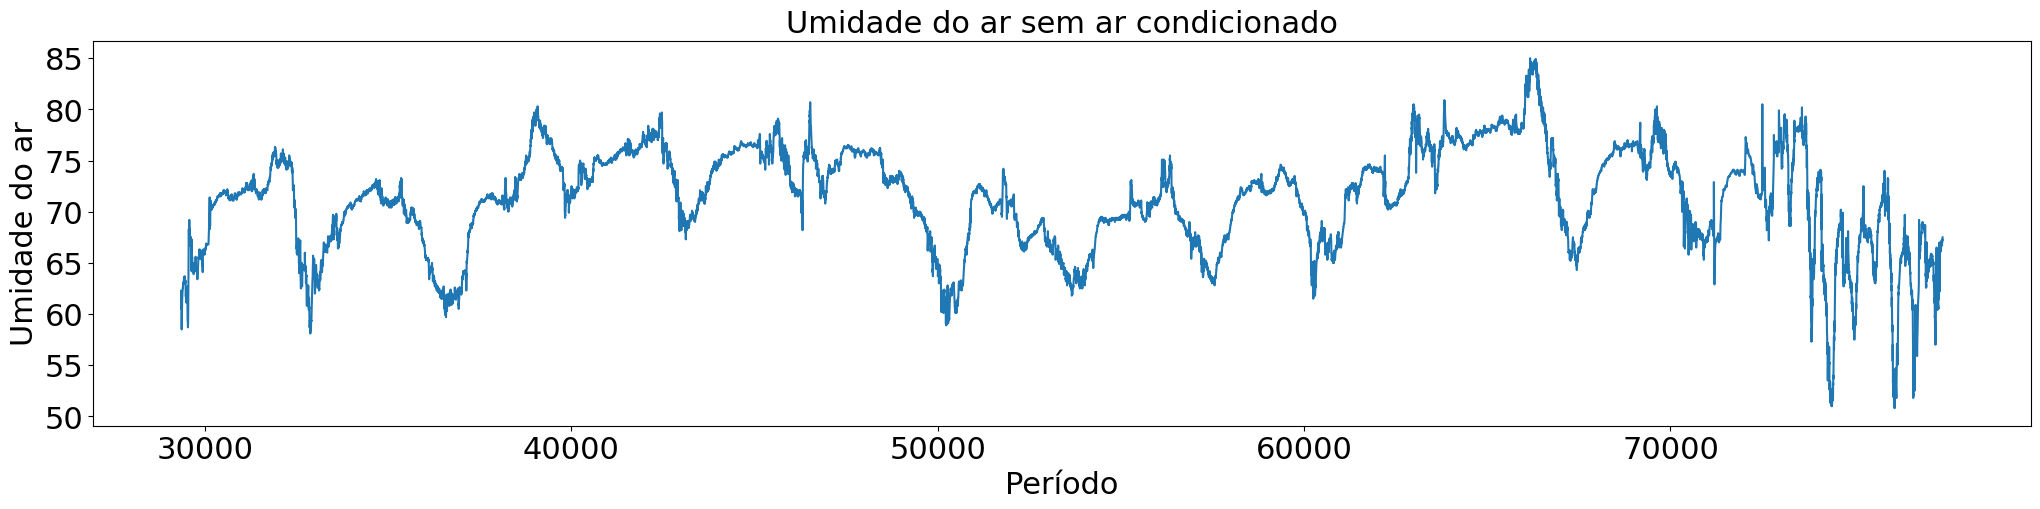

CPU times: user 542 ms, sys: 107 ms, total: 649 ms
Wall time: 542 ms


In [44]:
%%time
plt.figure(figsize=(25,5))
serie_semar.umid_ar.plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('Umidade do ar',size=22)
plt.title('Umidade do ar sem ar condicionado',size=22)

plt.savefig('data_umidade_ar_conjunto_tratado_original_sem_ar.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

# Agrupando dados a cada t minuto(s) utilizando a média

Vamos tentar reduzir o ruído.

Definindo os minutos

In [45]:
minutos = 30

Setando a data como index

In [46]:
serie_comar.set_index('data', inplace=True)
serie_semar.set_index('data', inplace=True)

In [47]:
serie_comar.head(2)

,temp_ar,umid_ar
data,,
2023-03-04 00:04:12,26.60,57.00
2023-03-04 00:09:14,26.60,58.00


Agrupando os valores de data para cada t minuto(s) pela média

In [48]:
%%time
dados_agrupados_minutos_comar = serie_comar.resample(str(minutos) + 'T').mean()
dados_agrupados_minutos_comar.head(2)

CPU times: user 11.1 ms, sys: 12 µs, total: 11.1 ms
Wall time: 16.7 ms


,temp_ar,umid_ar
data,,
2023-03-04 00:00:00,26.60,57.17
2023-03-04 00:30:00,26.60,58.00


In [49]:
%%time
dados_agrupados_minutos_semar = serie_semar.resample(str(minutos) + 'T').mean()
dados_agrupados_minutos_semar.head(2)

CPU times: user 3 ms, sys: 1.81 ms, total: 4.81 ms
Wall time: 4.75 ms


,temp_ar,umid_ar
data,,
2023-04-04 15:00:00,27.92,61.65
2023-04-04 15:30:00,27.45,62.93


Tamanho do conjunto gerado

In [50]:
dados_agrupados_minutos_comar.shape

(2688, 2)

In [51]:
dados_agrupados_minutos_semar.shape

(1026, 2)

Verificando nulos

In [52]:
dados_agrupados_minutos_comar.isnull().sum()

temp_ar    11
umid_ar    11
dtype: int64

In [53]:
dados_agrupados_minutos_semar.isnull().sum()

temp_ar    0
umid_ar    0
dtype: int64

Preenchendo nulos com os valores anteriores

In [54]:
dados_agrupados_minutos_comar.fillna(method="ffill", inplace = True)

Verificando novamente os nulos

In [55]:
dados_agrupados_minutos_comar.isnull().sum()

temp_ar    0
umid_ar    0
dtype: int64

# Gráficos

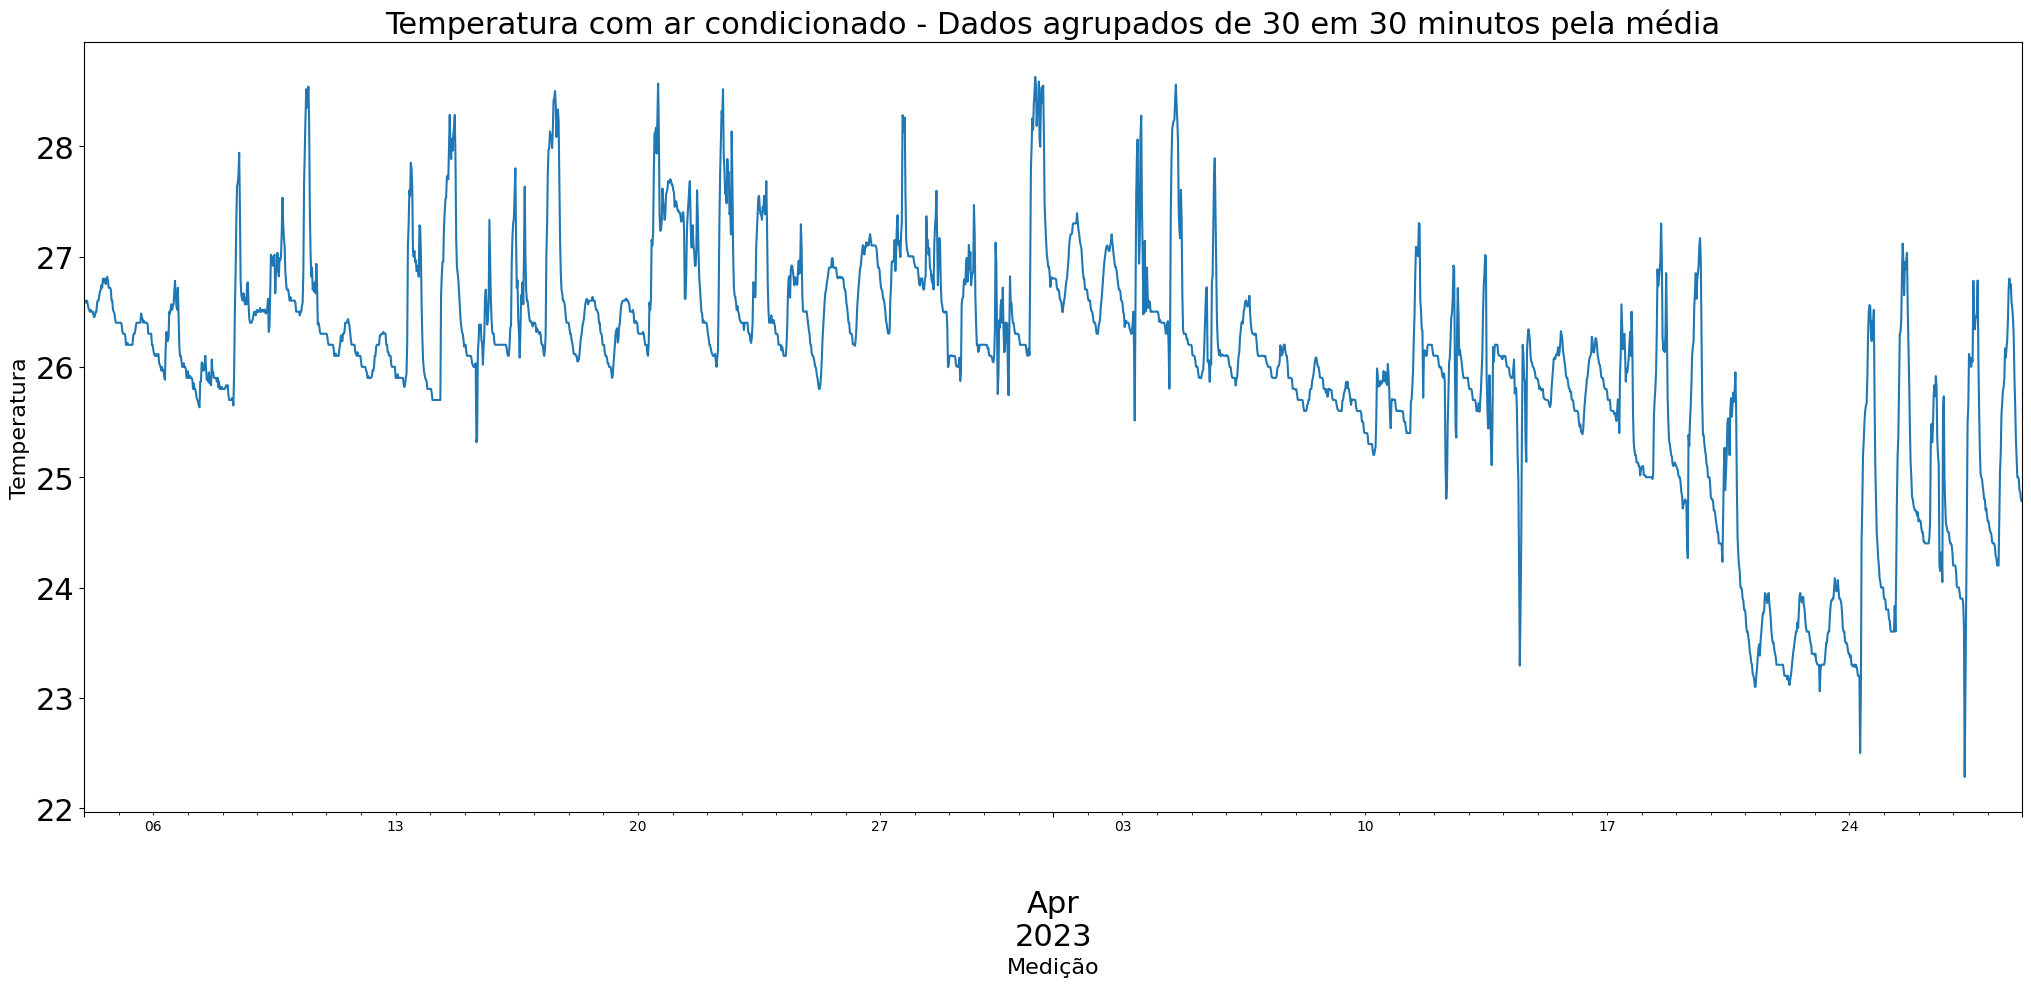

CPU times: user 1.08 s, sys: 125 ms, total: 1.2 s
Wall time: 1.09 s


In [56]:
%%time
plt.figure(figsize=(25,10))
dados_agrupados_minutos_comar['temp_ar'].plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Medição',size=16)
plt.ylabel('Temperatura',size=16)
plt.title(f'Temperatura com ar condicionado - Dados agrupados de {minutos} em {minutos} minutos pela média',size=22)

plt.savefig(f'data_temperatura_ar_conjunto_dados_agrupados_{minutos}_minutos.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

plt.show()

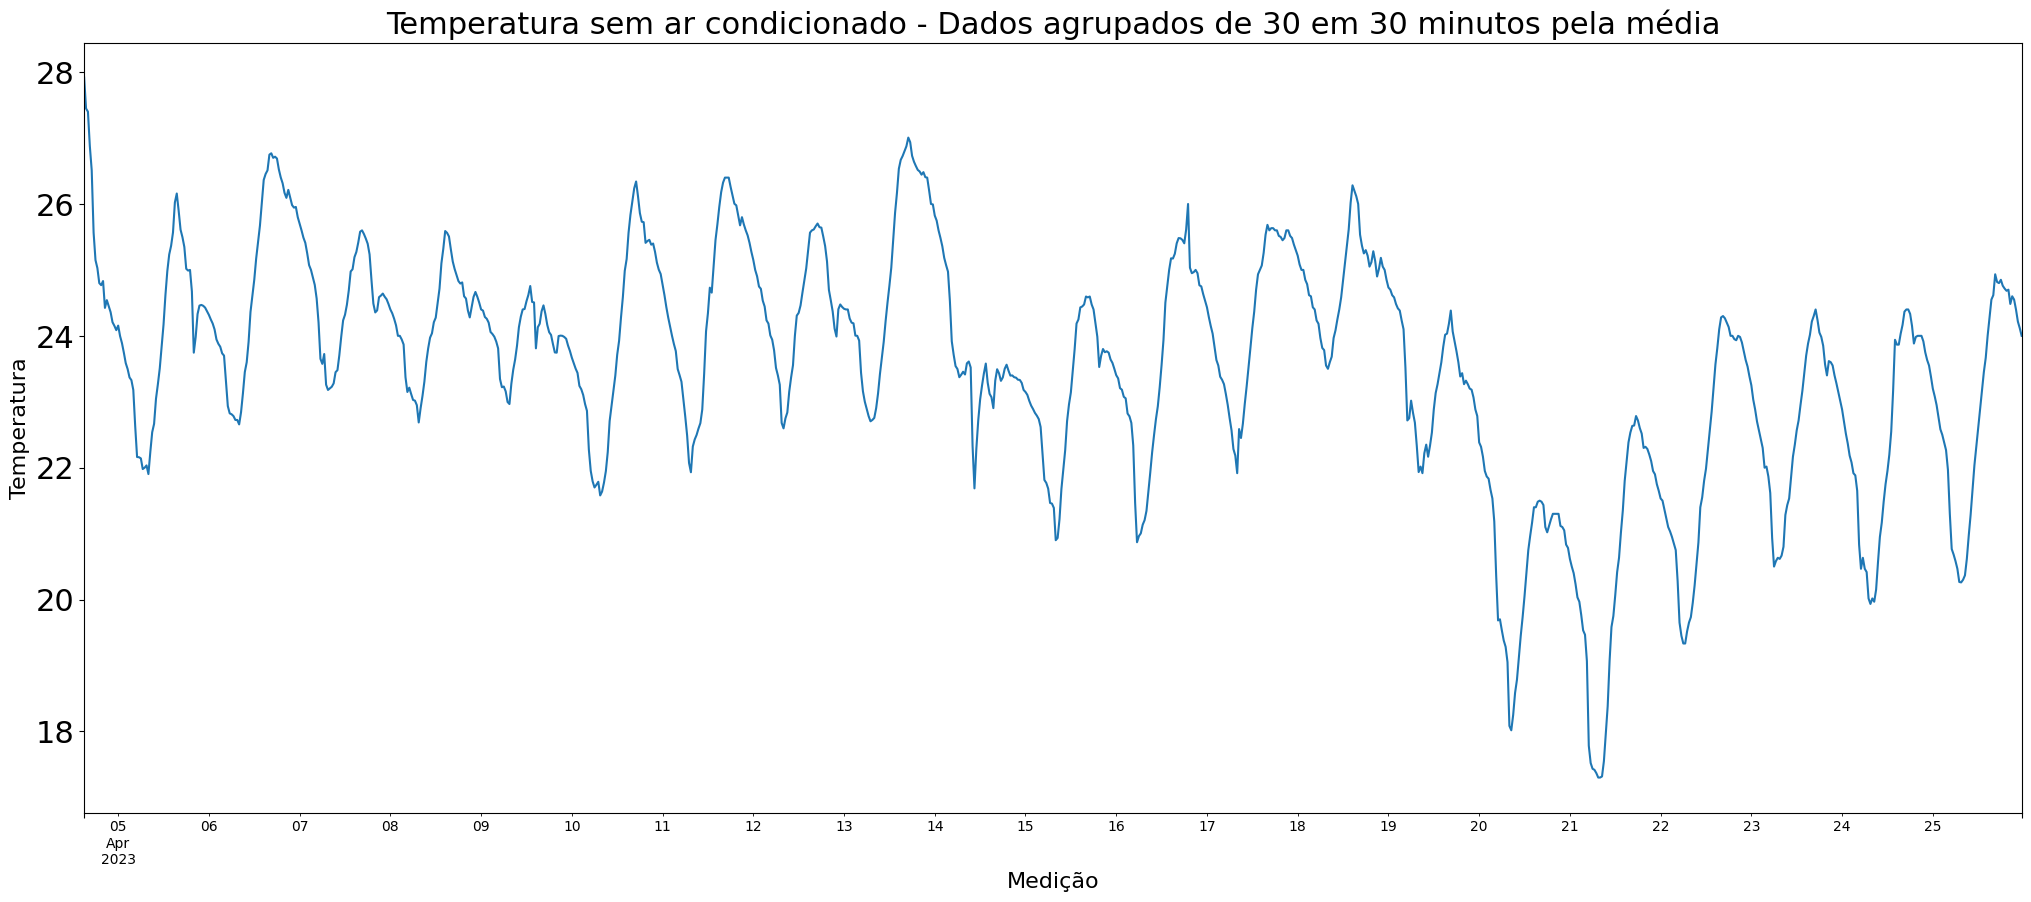

CPU times: user 787 ms, sys: 125 ms, total: 913 ms
Wall time: 826 ms


In [57]:
%%time
plt.figure(figsize=(25,10))
dados_agrupados_minutos_semar['temp_ar'].plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Medição',size=16)
plt.ylabel('Temperatura',size=16)
plt.title(f'Temperatura sem ar condicionado - Dados agrupados de {minutos} em {minutos} minutos pela média',size=22)

plt.savefig(f'data_temperatura_ar_conjunto_dados_agrupados_{minutos}_minutos_sem_ar.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

plt.show()

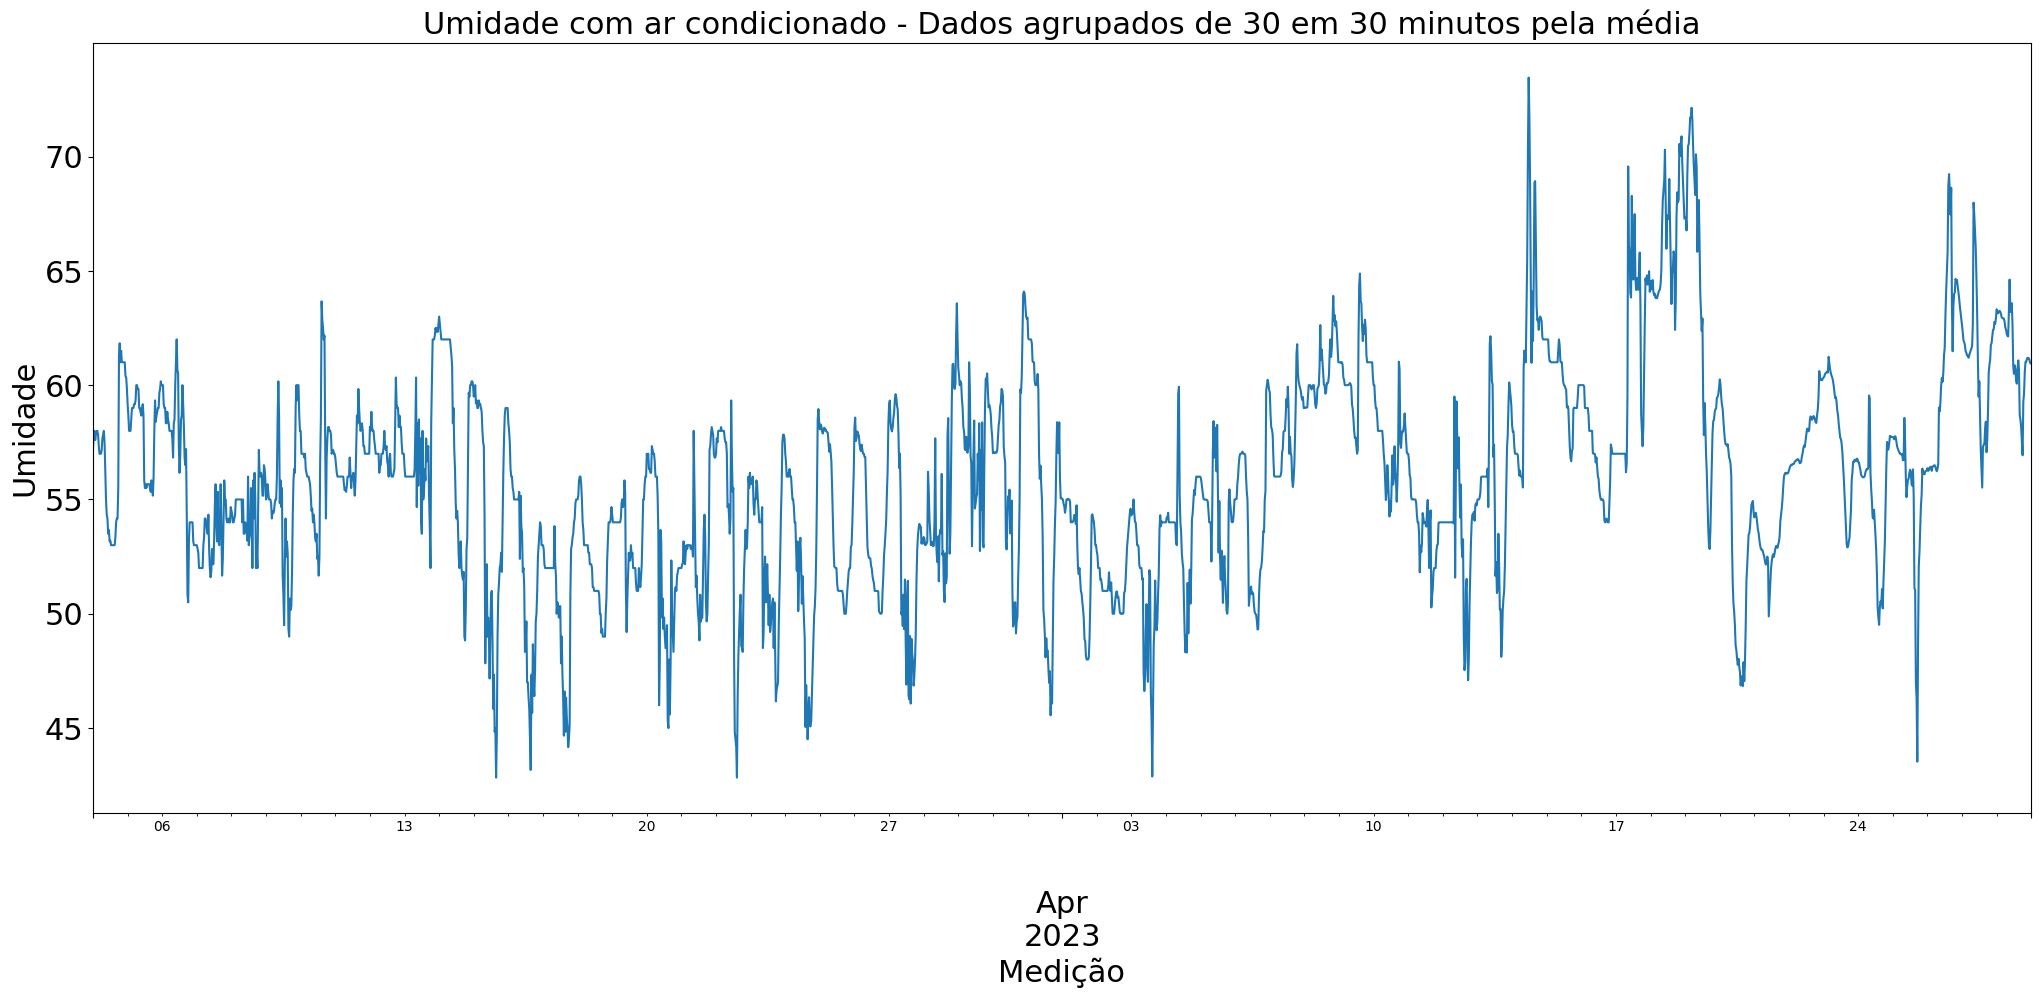

CPU times: user 1.06 s, sys: 115 ms, total: 1.18 s
Wall time: 1.09 s


In [58]:
%%time
plt.figure(figsize=(25,10))
dados_agrupados_minutos_comar['umid_ar'].plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Medição',size=22)
plt.ylabel('Umidade',size=22)
plt.title(f'Umidade com ar condicionado - Dados agrupados de {minutos} em {minutos} minutos pela média',size=22)

plt.savefig(f'data_umidade_ar_conjunto_dados_agrupados_{minutos}_minutos.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

plt.show()

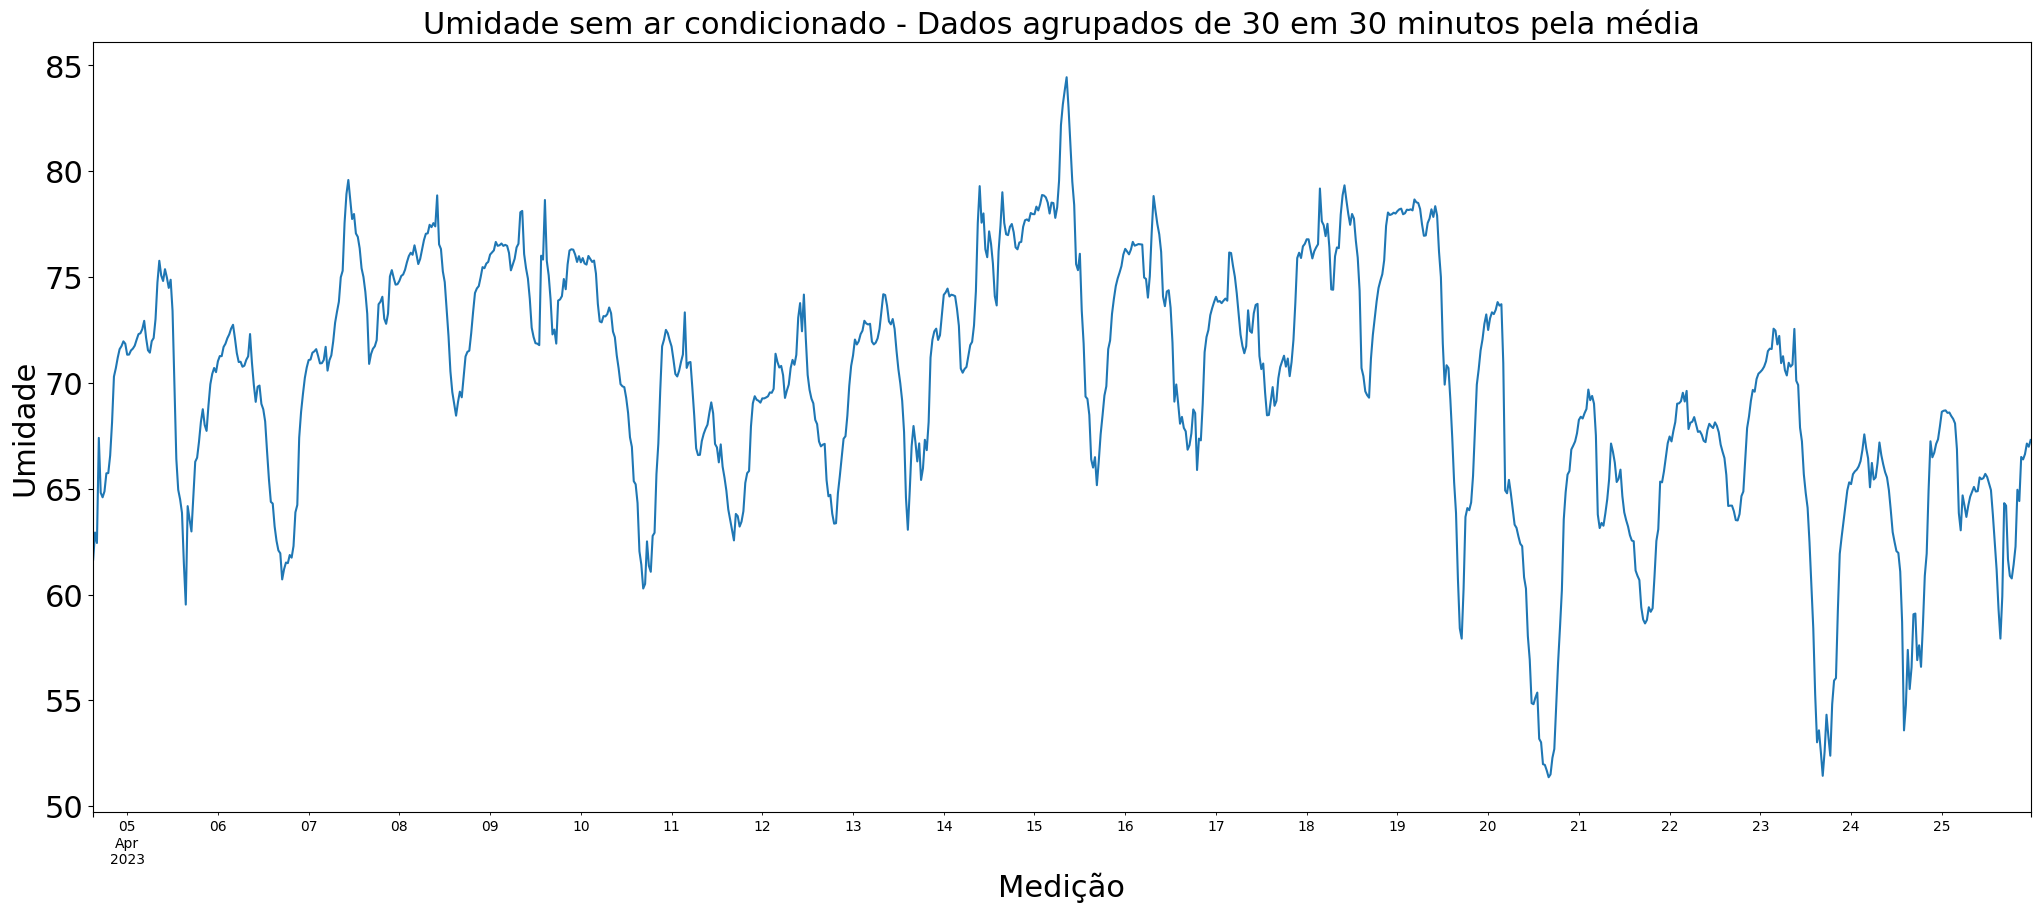

CPU times: user 828 ms, sys: 106 ms, total: 934 ms
Wall time: 846 ms


In [59]:
%%time
plt.figure(figsize=(25,10))
dados_agrupados_minutos_semar['umid_ar'].plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Medição',size=22)
plt.ylabel('Umidade',size=22)
plt.title(f'Umidade sem ar condicionado - Dados agrupados de {minutos} em {minutos} minutos pela média',size=22)

plt.savefig(f'data_umidade_ar_conjunto_dados_agrupados_{minutos}_minutos_sem_ar.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

plt.show()

# Suavização com média móvel e rolling

In [60]:
dados_agrupados_minutos_comar_cp = dados_agrupados_minutos_comar.copy()
dados_agrupados_minutos_semar_cp = dados_agrupados_minutos_semar.copy()

In [61]:
''' dados_agrupados_minutos_comar = dados_agrupados_minutos_comar_cp
dados_agrupados_minutos_semar = dados_agrupados_minutos_semar_cp '''

' dados_agrupados_minutos_comar = dados_agrupados_minutos_comar_cp\ndados_agrupados_minutos_semar = dados_agrupados_minutos_semar_cp '

In [62]:
dados_agrupados_minutos_comar['media_24_horas_temp_ar'] = dados_agrupados_minutos_comar.temp_ar.rolling(48).mean()
dados_agrupados_minutos_comar['media_24_horas_umid_ar'] = dados_agrupados_minutos_comar.umid_ar.rolling(48).mean()

dados_agrupados_minutos_semar['media_24_horas_temp_ar'] = dados_agrupados_minutos_semar.temp_ar.rolling(48).mean()
dados_agrupados_minutos_semar['media_24_horas_umid_ar'] = dados_agrupados_minutos_semar.umid_ar.rolling(48).mean()

In [63]:
dados_agrupados_minutos_comar.head(24)

,temp_ar,umid_ar,media_24_horas_temp_ar,media_24_horas_umid_ar
data,,,,
2023-03-04 00:00:00,26.60,57.17,NaN,NaN
2023-03-04 00:30:00,26.60,58.00,NaN,NaN
2023-03-04 01:00:00,26.60,58.00,NaN,NaN
2023-03-04 01:30:00,26.58,57.60,NaN,NaN
2023-03-04 02:00:00,26.60,57.83,NaN,NaN
2023-03-04 02:30:00,26.57,58.00,NaN,NaN
2023-03-04 03:00:00,26.53,58.00,NaN,NaN
2023-03-04 03:30:00,26.52,57.83,NaN,NaN
2023-03-04 04:00:00,26.50,57.33,NaN,NaN


Comparando a média móvel com os dados

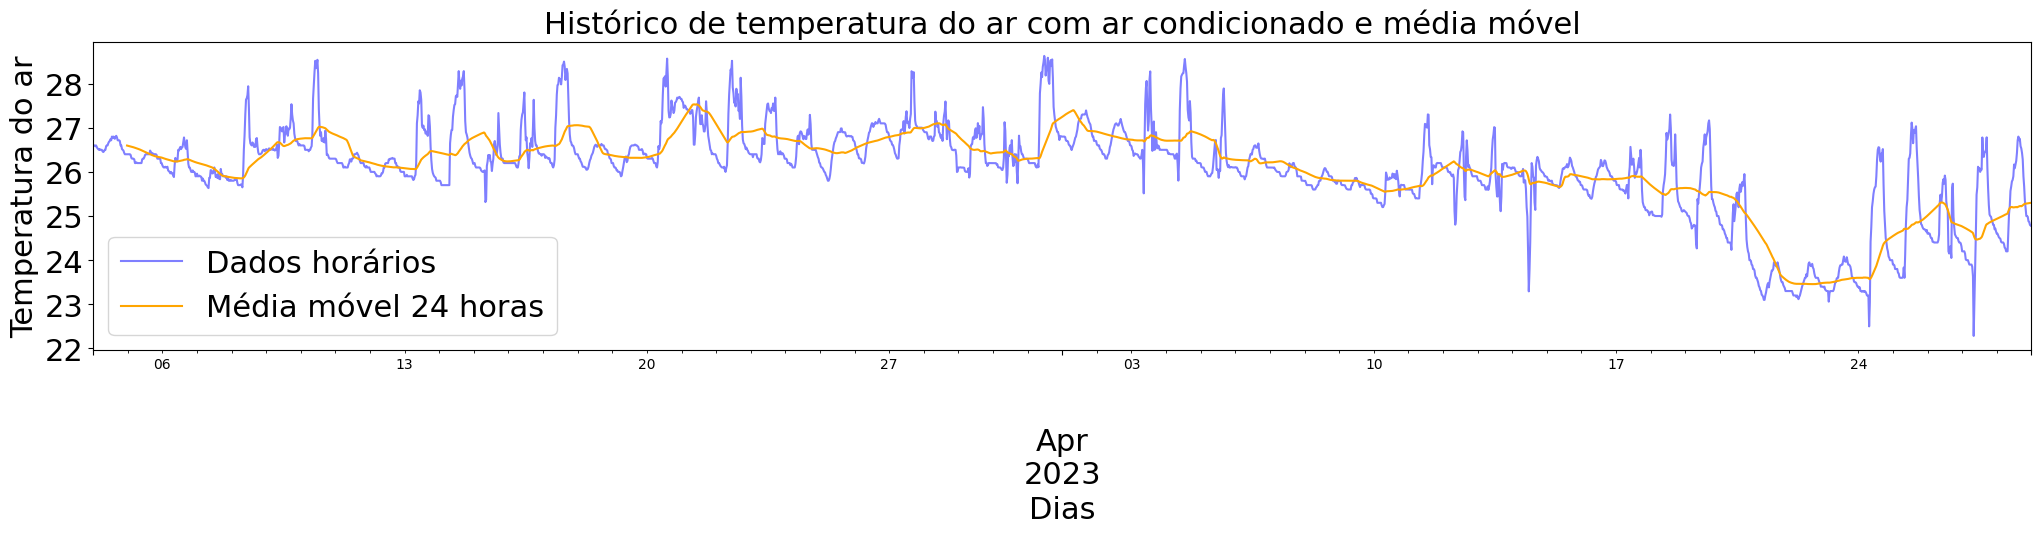

CPU times: user 1.17 s, sys: 112 ms, total: 1.28 s
Wall time: 1.2 s


In [64]:
%%time
plt.figure(figsize=(25,4))
dados_agrupados_minutos_comar.temp_ar.plot(c='blue',alpha=0.5) # Dados reais
dados_agrupados_minutos_comar['media_24_horas_temp_ar'].plot(c='orange') # Dados da média móvel
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dias',size=22)
plt.ylabel('Temperatura do ar',size=22)
plt.title('Histórico de temperatura do ar com ar condicionado e média móvel',size=22)
plt.legend(['Dados horários','Média móvel 24 horas'],fontsize=22)
plt.show()

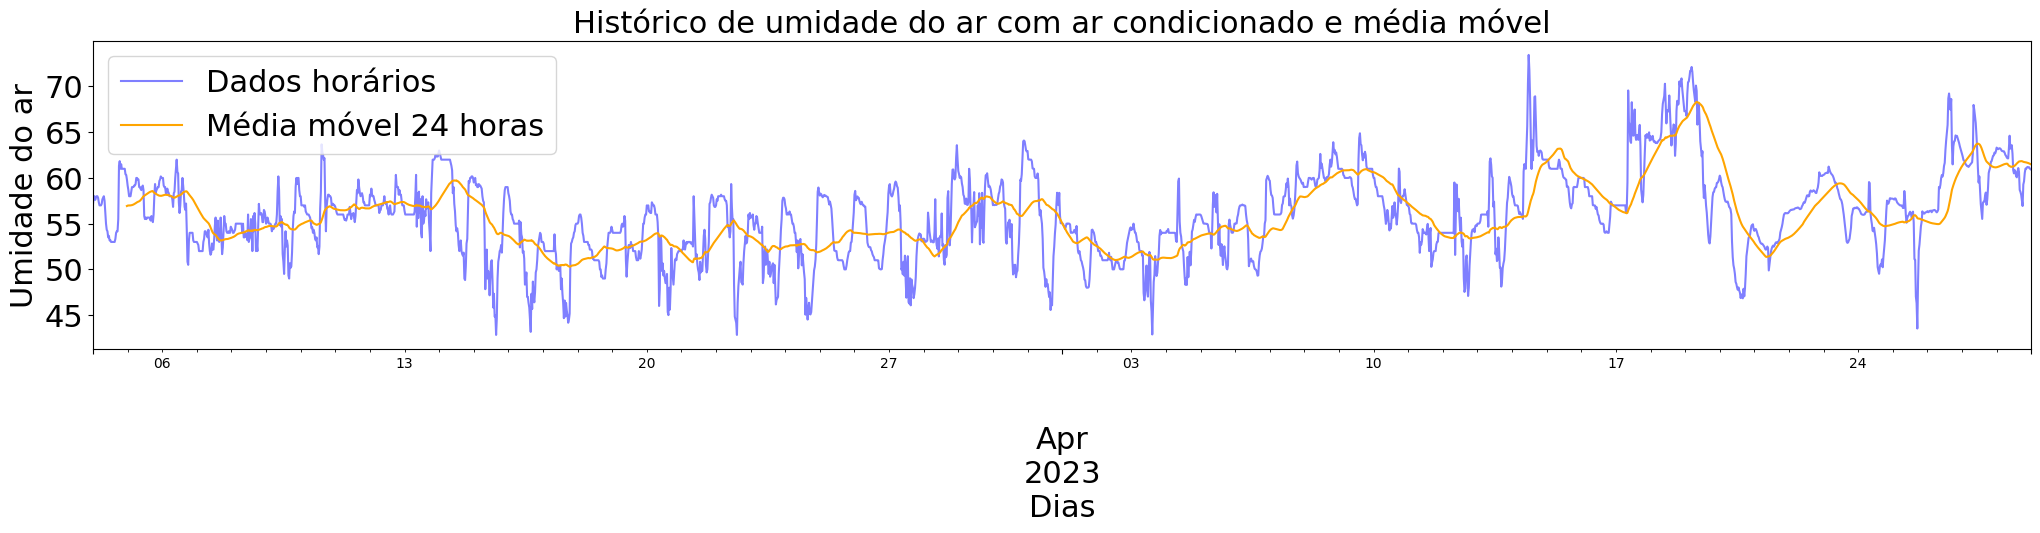

CPU times: user 1.16 s, sys: 43.1 ms, total: 1.2 s
Wall time: 1.24 s


In [65]:
%%time
plt.figure(figsize=(25,4))
dados_agrupados_minutos_comar.umid_ar.plot(c='blue',alpha=0.5) # Dados reais
dados_agrupados_minutos_comar['media_24_horas_umid_ar'].plot(c='orange') # Dados da média móvel
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dias',size=22)
plt.ylabel('Umidade do ar',size=22)
plt.title('Histórico de umidade do ar com ar condicionado e média móvel',size=22)
plt.legend(['Dados horários','Média móvel 24 horas'],fontsize=22)
plt.show()

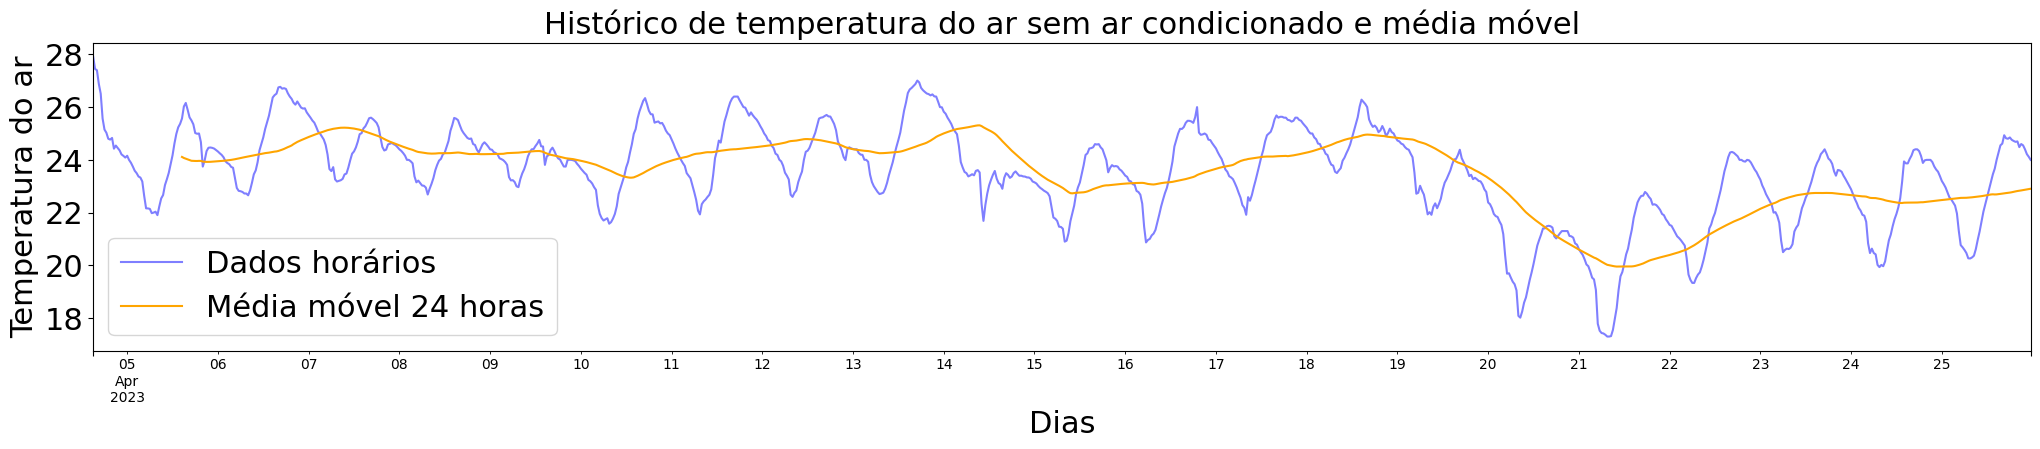

CPU times: user 684 ms, sys: 60.7 ms, total: 745 ms
Wall time: 760 ms


In [66]:
%%time
plt.figure(figsize=(25,4))
dados_agrupados_minutos_semar.temp_ar.plot(c='blue',alpha=0.5) # Dados reais
dados_agrupados_minutos_semar['media_24_horas_temp_ar'].plot(c='orange') # Dados da média móvel
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dias',size=22)
plt.ylabel('Temperatura do ar',size=22)
plt.title('Histórico de temperatura do ar sem ar condicionado e média móvel',size=22)
plt.legend(['Dados horários','Média móvel 24 horas'],fontsize=22)
plt.show()

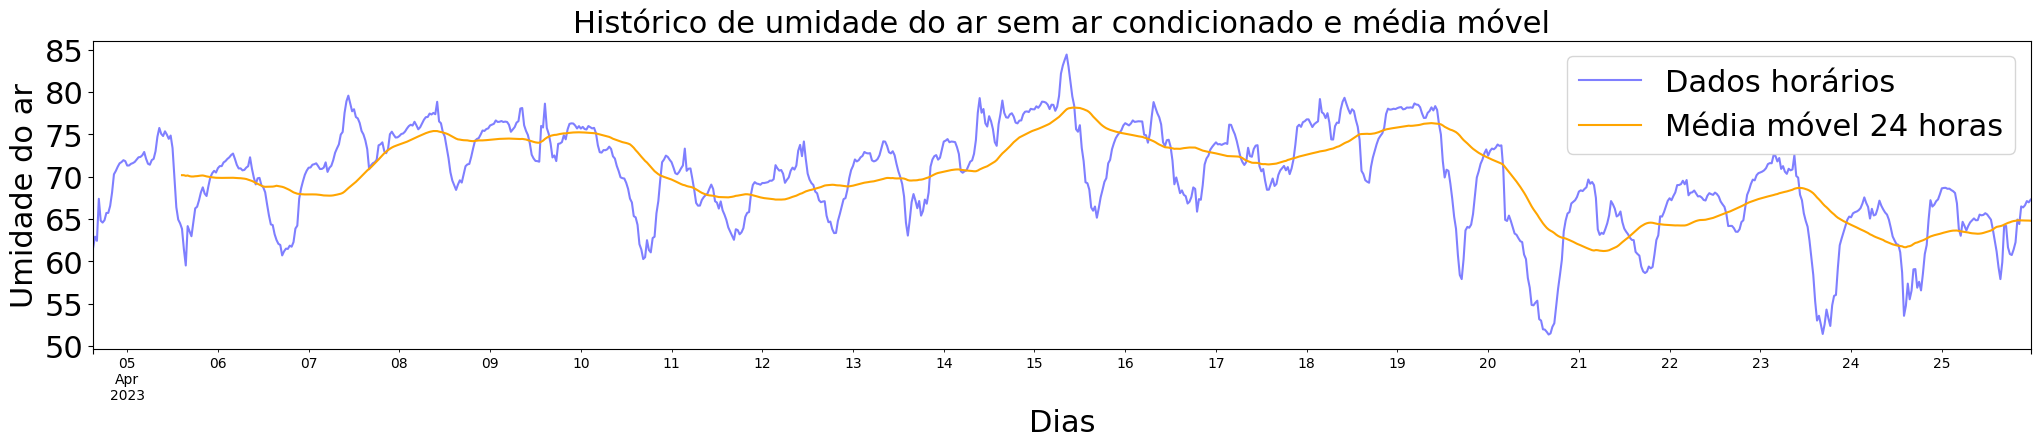

CPU times: user 632 ms, sys: 43.2 ms, total: 675 ms
Wall time: 686 ms


In [67]:
%%time
plt.figure(figsize=(25,4))
dados_agrupados_minutos_semar.umid_ar.plot(c='blue',alpha=0.5) # Dados reais
dados_agrupados_minutos_semar['media_24_horas_umid_ar'].plot(c='orange') # Dados da média móvel
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dias',size=22)
plt.ylabel('Umidade do ar',size=22)
plt.title('Histórico de umidade do ar sem ar condicionado e média móvel',size=22)
plt.legend(['Dados horários','Média móvel 24 horas'],fontsize=22)
plt.show()

# Feature engineering

Criando features com dados das últimas t horas passadas

In [68]:
horas_passadas = 24

In [69]:
def constroi_features_defasadas(base,lista_features,defasagem_maxima):
    # Constrói features defasadas com base na base original
    # Copia a base
    base_cop = base.copy()
    for feat in lista_features:       
        for i in range(1,defasagem_maxima+1):
            base_cop[str(feat)+'_def_'+str(i)] = base_cop[feat].shift(i)
    return base_cop

In [70]:
%%time
dados_agrupados_minutos_semar_eng = constroi_features_defasadas(dados_agrupados_minutos_semar,['temp_ar','umid_ar'],horas_passadas)
dados_agrupados_minutos_comar_eng = constroi_features_defasadas(dados_agrupados_minutos_comar,['temp_ar','umid_ar'],horas_passadas)

CPU times: user 63.6 ms, sys: 1.2 ms, total: 64.8 ms
Wall time: 62.2 ms


In [71]:
dados_agrupados_minutos_semar_eng.columns

Index(['temp_ar', 'umid_ar', 'media_24_horas_temp_ar',
       'media_24_horas_umid_ar', 'temp_ar_def_1', 'temp_ar_def_2',
       'temp_ar_def_3', 'temp_ar_def_4', 'temp_ar_def_5', 'temp_ar_def_6',
       'temp_ar_def_7', 'temp_ar_def_8', 'temp_ar_def_9', 'temp_ar_def_10',
       'temp_ar_def_11', 'temp_ar_def_12', 'temp_ar_def_13', 'temp_ar_def_14',
       'temp_ar_def_15', 'temp_ar_def_16', 'temp_ar_def_17', 'temp_ar_def_18',
       'temp_ar_def_19', 'temp_ar_def_20', 'temp_ar_def_21', 'temp_ar_def_22',
       'temp_ar_def_23', 'temp_ar_def_24', 'umid_ar_def_1', 'umid_ar_def_2',
       'umid_ar_def_3', 'umid_ar_def_4', 'umid_ar_def_5', 'umid_ar_def_6',
       'umid_ar_def_7', 'umid_ar_def_8', 'umid_ar_def_9', 'umid_ar_def_10',
       'umid_ar_def_11', 'umid_ar_def_12', 'umid_ar_def_13', 'umid_ar_def_14',
       'umid_ar_def_15', 'umid_ar_def_16', 'umid_ar_def_17', 'umid_ar_def_18',
       'umid_ar_def_19', 'umid_ar_def_20', 'umid_ar_def_21', 'umid_ar_def_22',
       'umid_ar_def_23', 

In [72]:
dados_agrupados_minutos_comar_eng.columns

Index(['temp_ar', 'umid_ar', 'media_24_horas_temp_ar',
       'media_24_horas_umid_ar', 'temp_ar_def_1', 'temp_ar_def_2',
       'temp_ar_def_3', 'temp_ar_def_4', 'temp_ar_def_5', 'temp_ar_def_6',
       'temp_ar_def_7', 'temp_ar_def_8', 'temp_ar_def_9', 'temp_ar_def_10',
       'temp_ar_def_11', 'temp_ar_def_12', 'temp_ar_def_13', 'temp_ar_def_14',
       'temp_ar_def_15', 'temp_ar_def_16', 'temp_ar_def_17', 'temp_ar_def_18',
       'temp_ar_def_19', 'temp_ar_def_20', 'temp_ar_def_21', 'temp_ar_def_22',
       'temp_ar_def_23', 'temp_ar_def_24', 'umid_ar_def_1', 'umid_ar_def_2',
       'umid_ar_def_3', 'umid_ar_def_4', 'umid_ar_def_5', 'umid_ar_def_6',
       'umid_ar_def_7', 'umid_ar_def_8', 'umid_ar_def_9', 'umid_ar_def_10',
       'umid_ar_def_11', 'umid_ar_def_12', 'umid_ar_def_13', 'umid_ar_def_14',
       'umid_ar_def_15', 'umid_ar_def_16', 'umid_ar_def_17', 'umid_ar_def_18',
       'umid_ar_def_19', 'umid_ar_def_20', 'umid_ar_def_21', 'umid_ar_def_22',
       'umid_ar_def_23', 

Criando features com dados das próximas t horas

In [73]:
proximas_horas = 12

In [74]:
def construcao_target(base,nome_feature_target,periodos_considerados):
    # Constrói a variável resposta usando feature_target agrupado pelo número periodos_considerados
    cols_target = []
    for i in range(periodos_considerados):
        nome_feature = nome_feature_target+'_'+str(i)
        cols_target.append(nome_feature)
        base[nome_feature] = base[nome_feature_target].shift(-i)
    # Consolidação final
    base['target'] = base[cols_target].mean(axis=1)
    # Retorna a base apenas com a coluna target, desconsiderando as demais
    return base.drop(cols_target,axis=1)

In [75]:
%%time
''' dados_agrupados_minutos_comar_eng = construcao_target(dados_agrupados_minutos_comar_eng,'temp_ar',12).dropna()
dados_agrupados_minutos_semar_eng = construcao_target(dados_agrupados_minutos_semar_eng,'temp_ar',12).dropna() '''

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.34 µs


" dados_agrupados_minutos_comar_eng = construcao_target(dados_agrupados_minutos_comar_eng,'temp_ar',12).dropna()\ndados_agrupados_minutos_semar_eng = construcao_target(dados_agrupados_minutos_semar_eng,'temp_ar',12).dropna() "

# Features de sazonalidade

In [76]:
%%time
''' dados_agrupados_minutos_semar_eng['mes'] = dados_agrupados_minutos_semar_eng.index.month '''
dados_agrupados_minutos_semar_eng['dia_da_semana'] = dados_agrupados_minutos_semar_eng.index.dayofweek

''' dados_agrupados_minutos_comar_eng['mes'] = dados_agrupados_minutos_comar_eng.index.month '''
dados_agrupados_minutos_comar_eng['dia_da_semana'] = dados_agrupados_minutos_comar_eng.index.dayofweek

CPU times: user 4.11 ms, sys: 905 µs, total: 5.02 ms
Wall time: 8.08 ms


In [77]:
dados_agrupados_minutos_semar_eng.columns

Index(['temp_ar', 'umid_ar', 'media_24_horas_temp_ar',
       'media_24_horas_umid_ar', 'temp_ar_def_1', 'temp_ar_def_2',
       'temp_ar_def_3', 'temp_ar_def_4', 'temp_ar_def_5', 'temp_ar_def_6',
       'temp_ar_def_7', 'temp_ar_def_8', 'temp_ar_def_9', 'temp_ar_def_10',
       'temp_ar_def_11', 'temp_ar_def_12', 'temp_ar_def_13', 'temp_ar_def_14',
       'temp_ar_def_15', 'temp_ar_def_16', 'temp_ar_def_17', 'temp_ar_def_18',
       'temp_ar_def_19', 'temp_ar_def_20', 'temp_ar_def_21', 'temp_ar_def_22',
       'temp_ar_def_23', 'temp_ar_def_24', 'umid_ar_def_1', 'umid_ar_def_2',
       'umid_ar_def_3', 'umid_ar_def_4', 'umid_ar_def_5', 'umid_ar_def_6',
       'umid_ar_def_7', 'umid_ar_def_8', 'umid_ar_def_9', 'umid_ar_def_10',
       'umid_ar_def_11', 'umid_ar_def_12', 'umid_ar_def_13', 'umid_ar_def_14',
       'umid_ar_def_15', 'umid_ar_def_16', 'umid_ar_def_17', 'umid_ar_def_18',
       'umid_ar_def_19', 'umid_ar_def_20', 'umid_ar_def_21', 'umid_ar_def_22',
       'umid_ar_def_23', 

In [78]:
dados_agrupados_minutos_comar_eng.columns

Index(['temp_ar', 'umid_ar', 'media_24_horas_temp_ar',
       'media_24_horas_umid_ar', 'temp_ar_def_1', 'temp_ar_def_2',
       'temp_ar_def_3', 'temp_ar_def_4', 'temp_ar_def_5', 'temp_ar_def_6',
       'temp_ar_def_7', 'temp_ar_def_8', 'temp_ar_def_9', 'temp_ar_def_10',
       'temp_ar_def_11', 'temp_ar_def_12', 'temp_ar_def_13', 'temp_ar_def_14',
       'temp_ar_def_15', 'temp_ar_def_16', 'temp_ar_def_17', 'temp_ar_def_18',
       'temp_ar_def_19', 'temp_ar_def_20', 'temp_ar_def_21', 'temp_ar_def_22',
       'temp_ar_def_23', 'temp_ar_def_24', 'umid_ar_def_1', 'umid_ar_def_2',
       'umid_ar_def_3', 'umid_ar_def_4', 'umid_ar_def_5', 'umid_ar_def_6',
       'umid_ar_def_7', 'umid_ar_def_8', 'umid_ar_def_9', 'umid_ar_def_10',
       'umid_ar_def_11', 'umid_ar_def_12', 'umid_ar_def_13', 'umid_ar_def_14',
       'umid_ar_def_15', 'umid_ar_def_16', 'umid_ar_def_17', 'umid_ar_def_18',
       'umid_ar_def_19', 'umid_ar_def_20', 'umid_ar_def_21', 'umid_ar_def_22',
       'umid_ar_def_23', 

Limpando dados nulos

In [79]:
dados_agrupados_minutos_comar_eng.dropna(inplace=True)

In [80]:
dados_agrupados_minutos_semar_eng.dropna(inplace=True)

# Separando features e target

In [81]:
%%time
X_comar = dados_agrupados_minutos_comar_eng.drop('temp_ar',axis=1)
y_comar = dados_agrupados_minutos_comar_eng.temp_ar

X_semar = dados_agrupados_minutos_semar_eng.drop('temp_ar',axis=1)
y_semar = dados_agrupados_minutos_semar_eng.temp_ar

CPU times: user 2.75 ms, sys: 0 ns, total: 2.75 ms
Wall time: 2.66 ms


In [82]:
X_comar.head()

,umid_ar,media_24_horas_temp_ar,media_24_horas_umid_ar,temp_ar_def_1,temp_ar_def_2,temp_ar_def_3,temp_ar_def_4,temp_ar_def_5,temp_ar_def_6,temp_ar_def_7,...,umid_ar_def_16,umid_ar_def_17,umid_ar_def_18,umid_ar_def_19,umid_ar_def_20,umid_ar_def_21,umid_ar_def_22,umid_ar_def_23,umid_ar_def_24,dia_da_semana
data,,,,,,,,,,,,,,,,,,,,,
2023-03-04 23:30:00,59.83,26.60,56.93,26.40,26.40,26.40,26.43,26.48,26.50,26.52,...,53.33,53.00,53.00,53.00,53.00,53.00,53.00,53.20,53.17,5
2023-03-05 00:00:00,59.17,26.59,56.97,26.40,26.40,26.40,26.40,26.43,26.48,26.50,...,54.00,53.33,53.00,53.00,53.00,53.00,53.00,53.00,53.20,6
2023-03-05 00:30:00,58.67,26.59,56.99,26.40,26.40,26.40,26.40,26.40,26.43,26.48,...,54.17,54.00,53.33,53.00,53.00,53.00,53.00,53.00,53.00,6
2023-03-05 01:00:00,58.00,26.58,56.99,26.40,26.40,26.40,26.40,26.40,26.40,26.43,...,54.17,54.17,54.00,53.33,53.00,53.00,53.00,53.00,53.00,6
2023-03-05 01:30:00,58.00,26.58,57.00,26.40,26.40,26.40,26.40,26.40,26.40,26.40,...,55.50,54.17,54.17,54.00,53.33,53.00,53.00,53.00,53.00,6


In [83]:
y_comar.head()

data
2023-03-04 23:30:00   26.40
2023-03-05 00:00:00   26.40
2023-03-05 00:30:00   26.40
2023-03-05 01:00:00   26.40
2023-03-05 01:30:00   26.40
Freq: 30T, Name: temp_ar, dtype: float64

In [84]:
X_semar.head()

,umid_ar,media_24_horas_temp_ar,media_24_horas_umid_ar,temp_ar_def_1,temp_ar_def_2,temp_ar_def_3,temp_ar_def_4,temp_ar_def_5,temp_ar_def_6,temp_ar_def_7,...,umid_ar_def_16,umid_ar_def_17,umid_ar_def_18,umid_ar_def_19,umid_ar_def_20,umid_ar_def_21,umid_ar_def_22,umid_ar_def_23,umid_ar_def_24,dia_da_semana
data,,,,,,,,,,,,,,,,,,,,,
2023-04-05 14:30:00,63.86,24.11,70.19,25.37,25.23,24.98,24.62,24.17,23.84,23.51,...,71.97,71.43,71.54,72.13,72.93,72.54,72.34,72.30,72.04,2
2023-04-05 15:00:00,61.45,24.07,70.19,25.57,25.37,25.23,24.98,24.62,24.17,23.84,...,72.12,71.97,71.43,71.54,72.13,72.93,72.54,72.34,72.30,2
2023-04-05 15:30:00,59.52,24.04,70.12,26.02,25.57,25.37,25.23,24.98,24.62,24.17,...,73.02,72.12,71.97,71.43,71.54,72.13,72.93,72.54,72.34,2
2023-04-05 16:00:00,64.18,24.01,70.15,26.16,26.02,25.57,25.37,25.23,24.98,24.62,...,74.74,73.02,72.12,71.97,71.43,71.54,72.13,72.93,72.54,2
2023-04-05 16:30:00,63.56,23.99,70.07,25.90,26.16,26.02,25.57,25.37,25.23,24.98,...,75.77,74.74,73.02,72.12,71.97,71.43,71.54,72.13,72.93,2


In [85]:
y_semar.head()

data
2023-04-05 14:30:00   25.57
2023-04-05 15:00:00   26.02
2023-04-05 15:30:00   26.16
2023-04-05 16:00:00   25.90
2023-04-05 16:30:00   25.61
Freq: 30T, Name: temp_ar, dtype: float64

# Conjuntos de treino e teste

Nosso conjunto de teste será de 5 dias

In [86]:
%%time
corte_treino_teste = '2023-04-24 00:00:00'

X_train_comar = X_comar[X_comar.index < corte_treino_teste]
X_test_comar = X_comar[X_comar.index >= corte_treino_teste]
X_train_semar = X_semar[X_semar.index < corte_treino_teste]
X_test_semar = X_semar[X_semar.index >= corte_treino_teste]

y_train_comar = y_comar[y_comar.index < corte_treino_teste]
y_test_comar = y_comar[y_comar.index >= corte_treino_teste]
y_train_semar = y_semar[y_semar.index < corte_treino_teste]
y_test_semar = y_semar[y_semar.index >= corte_treino_teste]

print('Tamanho do treino com ar condicionado '+str(len(X_train_comar)))
print('Tamanho do teste com ar condicionado '+str(len(X_test_comar)))
print('Tamanho do treino com ar condicionado '+str(len(X_train_semar)))
print('Tamanho do teste com ar condicionado '+str(len(X_test_semar)))

Tamanho do treino com ar condicionado 2401
Tamanho do teste com ar condicionado 240
Tamanho do treino com ar condicionado 883
Tamanho do teste com ar condicionado 96
CPU times: user 8.4 ms, sys: 27 µs, total: 8.43 ms
Wall time: 8.78 ms


In [87]:
X_train_comar.isnull().sum()

umid_ar                   0
media_24_horas_temp_ar    0
media_24_horas_umid_ar    0
temp_ar_def_1             0
temp_ar_def_2             0
temp_ar_def_3             0
temp_ar_def_4             0
temp_ar_def_5             0
temp_ar_def_6             0
temp_ar_def_7             0
temp_ar_def_8             0
temp_ar_def_9             0
temp_ar_def_10            0
temp_ar_def_11            0
temp_ar_def_12            0
temp_ar_def_13            0
temp_ar_def_14            0
temp_ar_def_15            0
temp_ar_def_16            0
temp_ar_def_17            0
temp_ar_def_18            0
temp_ar_def_19            0
temp_ar_def_20            0
temp_ar_def_21            0
temp_ar_def_22            0
temp_ar_def_23            0
temp_ar_def_24            0
umid_ar_def_1             0
umid_ar_def_2             0
umid_ar_def_3             0
umid_ar_def_4             0
umid_ar_def_5             0
umid_ar_def_6             0
umid_ar_def_7             0
umid_ar_def_8             0
umid_ar_def_9       

# Crossvalidação em séries temporais

Visualizando crossvalidação nas séries temporais

In [88]:
%%time
from sklearn.model_selection import TimeSeriesSplit

ts_semar = TimeSeriesSplit(n_splits=5).split(X_train_semar,y_train_semar)
ts_semar

ts_comar = TimeSeriesSplit(n_splits=5).split(X_train_comar,y_train_comar)
ts_comar

CPU times: user 79 µs, sys: 0 ns, total: 79 µs
Wall time: 84.2 µs


<generator object TimeSeriesSplit.split at 0x7f9e8e5d7a00>

Tamanho de cada fold geraco com TimeSeriesSplit

In [89]:
%%time
i=1
for train_index_semar, test_index_semar in TimeSeriesSplit(n_splits=5).split(X_train_semar,y_train_semar):
    #print(train_index)
    print('Fold '+str(i))
    print('Conjunto de treino: '+str(len(X_semar.iloc[train_index_semar]))+' registros')
    print('Conjunto de teste: '+str(len(X_semar.iloc[test_index_semar]))+' registros')
    print('---')
    i = i+1

Fold 1
Conjunto de treino: 148 registros
Conjunto de teste: 147 registros
---
Fold 2
Conjunto de treino: 295 registros
Conjunto de teste: 147 registros
---
Fold 3
Conjunto de treino: 442 registros
Conjunto de teste: 147 registros
---
Fold 4
Conjunto de treino: 589 registros
Conjunto de teste: 147 registros
---
Fold 5
Conjunto de treino: 736 registros
Conjunto de teste: 147 registros
---
CPU times: user 12.5 ms, sys: 2.07 ms, total: 14.6 ms
Wall time: 15.9 ms


In [90]:
%%time
i=1
for train_index_comar, test_index_comar in TimeSeriesSplit(n_splits=5).split(X_train_comar,y_train_comar):
    #print(train_index)
    print('Fold '+str(i))
    print('Conjunto de treino: '+str(len(X_comar.iloc[train_index_comar]))+' registros')
    print('Conjunto de teste: '+str(len(X_comar.iloc[test_index_comar]))+' registros')
    print('---')
    i = i+1

Fold 1
Conjunto de treino: 401 registros
Conjunto de teste: 400 registros
---
Fold 2
Conjunto de treino: 801 registros
Conjunto de teste: 400 registros
---
Fold 3
Conjunto de treino: 1201 registros
Conjunto de teste: 400 registros
---
Fold 4
Conjunto de treino: 1601 registros
Conjunto de teste: 400 registros
---
Fold 5
Conjunto de treino: 2001 registros
Conjunto de teste: 400 registros
---
CPU times: user 14.7 ms, sys: 1.15 ms, total: 15.8 ms
Wall time: 17.1 ms


# Métrica utilizada para escolher o melhor modelo

Será utilizada a mean_absolute_error (MSE), que é a média das diferenças entre a variável verdadeira e a predita em módulo. O objetivo é encontrar o modelo com menor MAE.

In [91]:
modelos_candidatos = {'Árvore':DecisionTreeRegressor(max_depth=5),
                      'RandomForest':RandomForestRegressor(max_depth=5),
                      'LGBM':LGBMRegressor(max_depth=5)
                     }

In [92]:
%%time
avaliacao_comar = {}
for nome_comar,model_comar in modelos_candidatos.items():
    # Avalia a crossvalidação
    score = cross_val_score(model_comar, # Escolhendo o nosso modelo da vez
                            X_train_comar, y_train_comar, # Nossos dados, excluindo o teste
                            cv=TimeSeriesSplit(n_splits=5), # Validação cruzada temporal
                            scoring='neg_mean_absolute_error', # Usando a métrica MAE
                           n_jobs=8 # Número de processadores, para ser mais rápido
                           ).mean() # Tirando a média de todos os folds
    avaliacao_comar[nome_comar] = -score # -score e não score para tornar o número positivo

CPU times: user 262 ms, sys: 217 ms, total: 479 ms
Wall time: 18.4 s


In [93]:
%%time
avaliacao_semar = {}
for nome_semar,model_semar in modelos_candidatos.items():
    # Avalia a crossvalidação
    score = cross_val_score(model_semar, # Escolhendo o nosso modelo da vez
                            X_train_semar, y_train_semar, # Nossos dados, excluindo o teste
                            cv=TimeSeriesSplit(n_splits=5), # Validação cruzada temporal
                            scoring='neg_mean_absolute_error', # Usando a métrica MAE
                           n_jobs=8 # Número de processadores, para ser mais rápido
                           ).mean() # Tirando a média de todos os folds
    avaliacao_semar[nome_semar] = -score # -score e não score para tornar o número positivo

CPU times: user 85.1 ms, sys: 4.6 ms, total: 89.7 ms
Wall time: 4.16 s


Comparando métricas de erros dos modelos

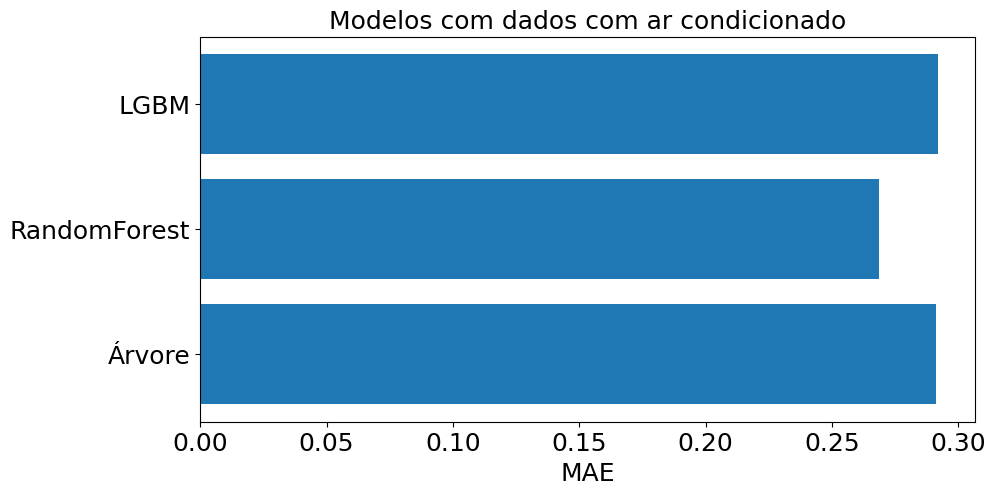

CPU times: user 206 ms, sys: 110 ms, total: 316 ms
Wall time: 200 ms


In [94]:
%%time
plt.figure(figsize=(10,5))
plt.barh(*zip(*avaliacao_comar.items()))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Modelos com dados com ar condicionado',size=18)
plt.xlabel('MAE',size=18)
plt.show()

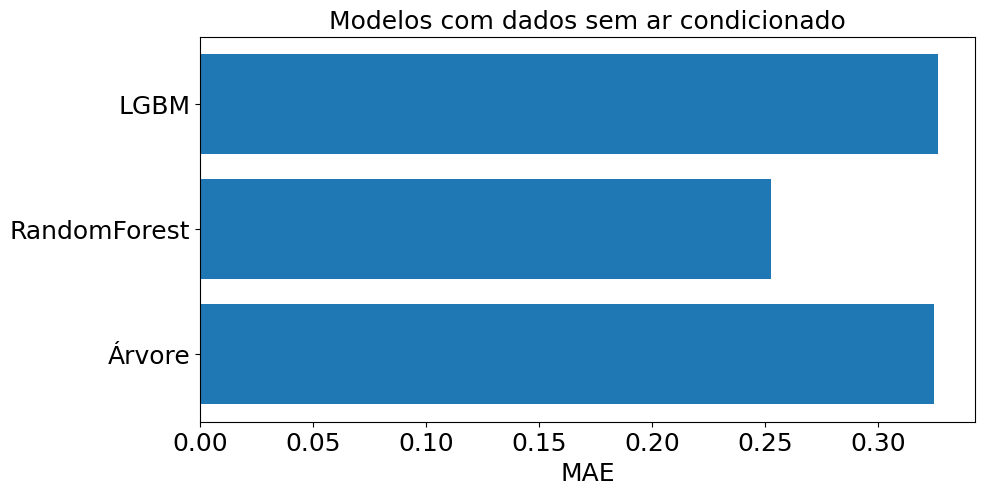

In [95]:
plt.figure(figsize=(10,5))
plt.barh(*zip(*avaliacao_semar.items()))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Modelos com dados sem ar condicionado',size=18)
plt.xlabel('MAE',size=18)
plt.show()

# Comparação do modelo com a média móvel

## Dados com ar condicionado

O melhor modelo com dados com ar condicionado foi o RandomForestRegressor.

In [96]:
%%time
scores_comar = -cross_val_score(RandomForestRegressor(), # Escolhendo o nosso modelo da vez
                    X_train_comar, y_train_comar, # Nossos dados, excluindo o teste
                    cv=TimeSeriesSplit(n_splits=10), # Validação cruzada temporal
                    scoring='neg_mean_absolute_error', # Usando a métrica MAE
                   n_jobs=8 # Número de processadores, para rodar mais rápido
                         ) # Tirando a média de todos os folds

CPU times: user 256 ms, sys: 34.5 ms, total: 290 ms
Wall time: 35.3 s


In [97]:
%%time
y_mediamovel_comar = y_test_comar.rolling(window=30,closed='left').mean().dropna()

# Selecionando para validação os mesmos índices
X_valid_comar = X_comar.loc[y_mediamovel_comar.index]
y_valid_comar = y_comar.loc[y_mediamovel_comar.index]

CPU times: user 4.24 ms, sys: 0 ns, total: 4.24 ms
Wall time: 6.21 ms


In [98]:
%%time
metricas_comar = []
for index_train_comar, index_test_comar in TimeSeriesSplit(n_splits=10).split(X_valid_comar,y_valid_comar):
    # Dados de treino
    x_tr = X_valid_comar.iloc[index_train_comar]
    y_tr = y_valid_comar.iloc[index_train_comar]
    x_te = X_valid_comar.iloc[index_test_comar]
    y_te = y_valid_comar.iloc[index_test_comar]
    y_mdmv = y_mediamovel_comar[index_test_comar]
    # Treinando um modelo e ajustando aos dados de treino
    model = RandomForestRegressor().fit(x_tr,y_tr)
    # Prevendo nos dados de teste
    y_pr = model.predict(x_te)
    # Calculando a métrica (MAE) no teste 
    mae_model = mean_absolute_error(y_te,y_pr)
    mae_mdmv = mean_absolute_error(y_te,y_mdmv)
    mae_relativo = mae_model/mae_mdmv
    metricas_comar.append(mae_relativo)

CPU times: user 3.09 s, sys: 20.2 ms, total: 3.11 s
Wall time: 3.11 s


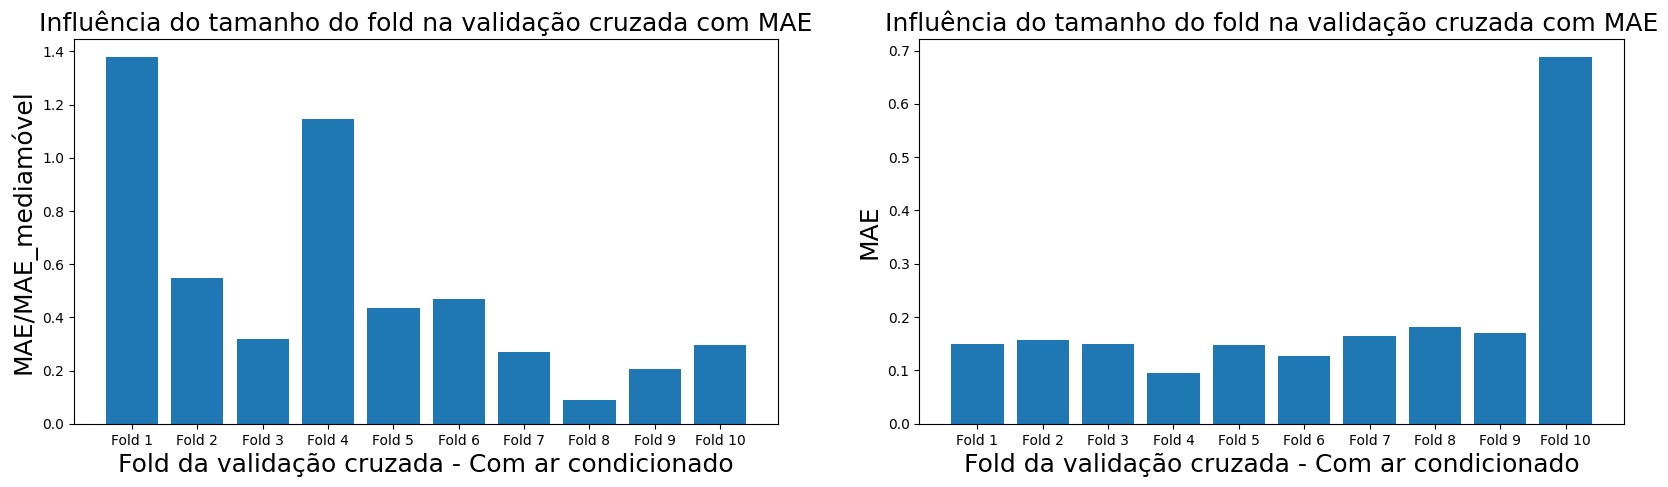

CPU times: user 525 ms, sys: 114 ms, total: 639 ms
Wall time: 518 ms


In [99]:
%%time
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].bar(height=metricas_comar,x=['Fold '+str(i) for i in range(1,11)])
ax[0].set_xlabel('Fold da validação cruzada - Com ar condicionado',size=18)
ax[0].set_ylabel('MAE/MAE_mediamóvel',size=18)
ax[0].set_title('Influência do tamanho do fold na validação cruzada com MAE',size=18)
ax[1].bar(height=scores_comar,x=['Fold '+str(i) for i in range(1,11)])
ax[1].set_xlabel('Fold da validação cruzada - Com ar condicionado',size=18)
ax[1].set_ylabel('MAE',size=18)
ax[1].set_title('Influência do tamanho do fold na validação cruzada com MAE',size=18)
plt.show()

Nosso modelo se saiu melhor que a média móvel, pois em cada fold vemos um MAE bem menor. Exceto no fold 10.

## Dados sem ar condicionado

O melhor modelo dos dados sem ar condicionado foi o RandomForest.

In [100]:
%%time
scores_semar = -cross_val_score(RandomForestRegressor(), # Escolhendo o nosso modelo da vez
                    X_train_semar, y_train_semar, # Nossos dados, excluindo o teste
                    cv=TimeSeriesSplit(n_splits=10), # Validação cruzada temporal
                    scoring='neg_mean_absolute_error', # Usando a métrica MAE
                   n_jobs=8 # Número de processadores, para rodar mais rápido
                         ) # Tirando a média de todos os folds

CPU times: user 110 ms, sys: 6.76 ms, total: 116 ms
Wall time: 11.1 s


In [101]:
%%time
y_mediamovel_semar = y_test_semar.rolling(window=30,closed='left').mean().dropna()

# Selecionando para validação os mesmos índices
X_valid_semar = X_semar.loc[y_mediamovel_semar.index]
y_valid_semar = y_semar.loc[y_mediamovel_semar.index]

CPU times: user 3.32 ms, sys: 34 µs, total: 3.35 ms
Wall time: 2.97 ms


In [102]:
y_test_semar.shape

(96,)

In [103]:
%%time
metricas_semar = []
for index_train_semar, index_test_semar in TimeSeriesSplit(n_splits=10).split(X_valid_semar,y_valid_semar):
    # Dados de treino
    x_tr = X_valid_semar.iloc[index_train_semar]
    y_tr = y_valid_semar.iloc[index_train_semar]
    x_te = X_valid_semar.iloc[index_test_semar]
    y_te = y_valid_semar.iloc[index_test_semar]
    y_mdmv = y_mediamovel_semar[index_test_semar]
    # Treinando um modelo e ajustando aos dados de treino
    model = RandomForestRegressor().fit(x_tr,y_tr)
    # Prevendo nos dados de teste
    y_pr = model.predict(x_te)
    # Calculando a métrica (MAE) no teste 
    mae_model = mean_absolute_error(y_te,y_pr)
    mae_mdmv = mean_absolute_error(y_te,y_mdmv)
    mae_relativo = mae_model/mae_mdmv
    metricas_semar.append(mae_relativo)

CPU times: user 1.76 s, sys: 17.4 ms, total: 1.78 s
Wall time: 1.79 s


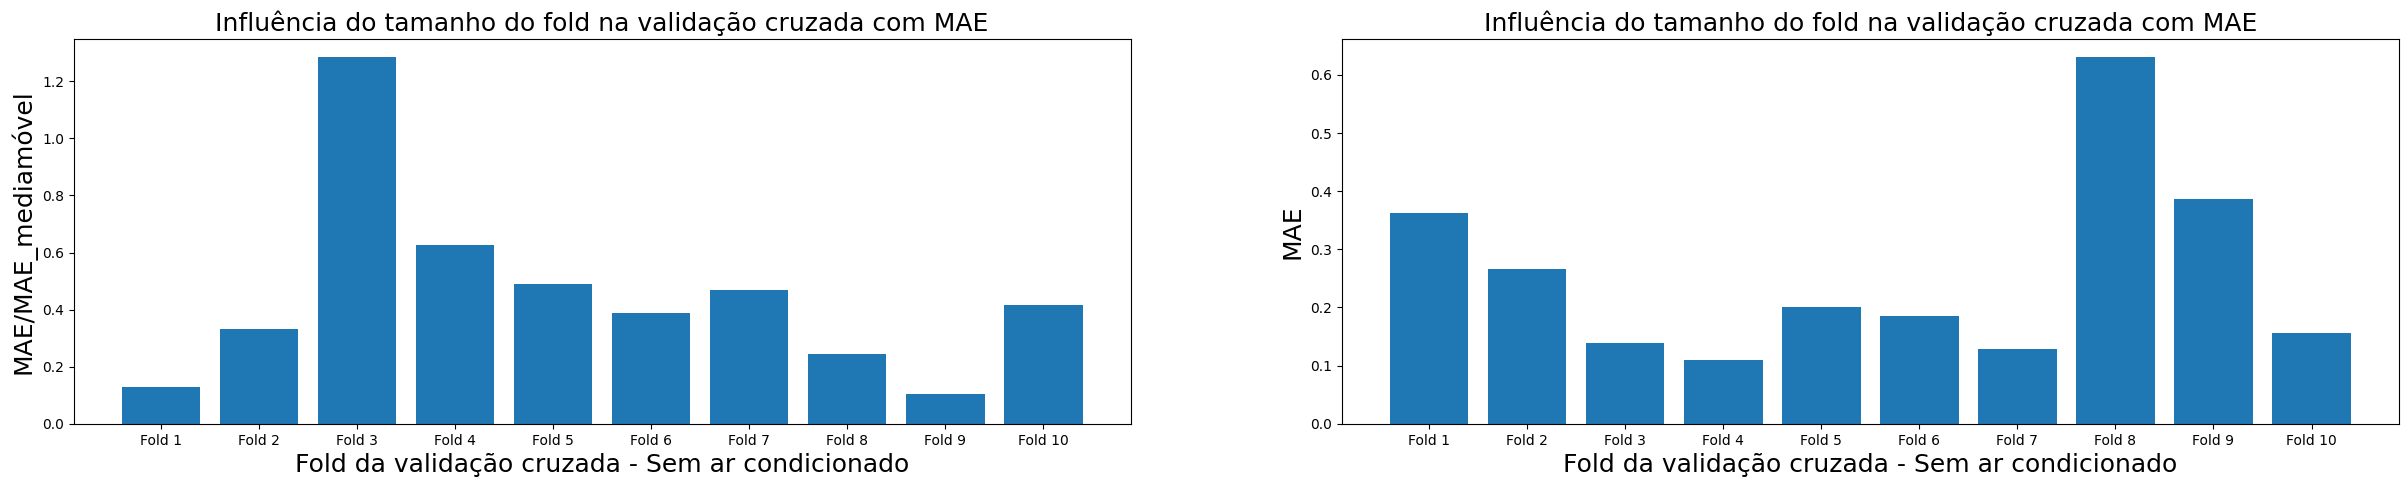

In [104]:
fig, ax = plt.subplots(1,2, figsize=(30,5))
ax[0].bar(height=metricas_semar,x=['Fold '+str(i) for i in range(1,11)])
ax[0].set_xlabel('Fold da validação cruzada - Sem ar condicionado',size=18)
ax[0].set_ylabel('MAE/MAE_mediamóvel',size=18)
ax[0].set_title('Influência do tamanho do fold na validação cruzada com MAE',size=18)
ax[1].bar(height=scores_semar,x=['Fold '+str(i) for i in range(1,11)])
ax[1].set_xlabel('Fold da validação cruzada - Sem ar condicionado',size=18)
ax[1].set_ylabel('MAE',size=18)
ax[1].set_title('Influência do tamanho do fold na validação cruzada com MAE',size=18)
plt.show()

Esse modelo não ficou muito bom em relação à média móvel.

# Otimização de Hiperparâmetros e modelo final

Utilizando o GridSearchCV  para encontrar os melhores hiperparâmetros

## Dados com ar condicionado

O melhor modelo foi o RandomForestRegressor, então precisamos encontrar os melhores hiperparâmetros para esse modelo.

In [121]:
''' param_grid = {
  'bootstrap': [True, False],
  'max_depth': [10, 20, 30, 40, None],
  'min_samples_leaf': [1, 2, 4],
  'min_samples_split': [2, 5, 10],
  'n_estimators': [10,100,150,200]} '''

In [ ]:
''' %%time
rcv = RandomizedSearchCV(RandomForestRegressor(), param_distributions = param_grid,cv = TimeSeriesSplit(n_splits=3),
                        scoring='neg_mean_absolute_error', verbose=True, n_jobs = -1, n_iter = 50, random_state=42)
rcv.fit(X_train_comar,y_train_comar) '''

In [ ]:
''' melhores_parametros = rcv.best_params_
rcv.best_params_ '''

In [127]:
%%time
modelo = RandomForestRegressor().fit(X_train_comar,y_train_comar)
y_pred_final_comar = pd.Series(modelo.predict(X_comar),index=X_comar.index)

CPU times: user 10 s, sys: 5.28 ms, total: 10 s
Wall time: 10.4 s


Plotando os dados de treino e teste para 5 dias do conjunto de teste

In [128]:
y_mediamovel_comar.index

DatetimeIndex(['2023-04-24 15:00:00', '2023-04-24 15:30:00',
               '2023-04-24 16:00:00', '2023-04-24 16:30:00',
               '2023-04-24 17:00:00', '2023-04-24 17:30:00',
               '2023-04-24 18:00:00', '2023-04-24 18:30:00',
               '2023-04-24 19:00:00', '2023-04-24 19:30:00',
               ...
               '2023-04-28 19:00:00', '2023-04-28 19:30:00',
               '2023-04-28 20:00:00', '2023-04-28 20:30:00',
               '2023-04-28 21:00:00', '2023-04-28 21:30:00',
               '2023-04-28 22:00:00', '2023-04-28 22:30:00',
               '2023-04-28 23:00:00', '2023-04-28 23:30:00'],
              dtype='datetime64[ns]', name='data', length=210, freq='30T')

In [129]:
y_mediamovel_comar_geral = y_comar.rolling(window=48,closed='left').mean().dropna()
x_pl_comar = X_comar[(X_comar.index >= '2023-04-24 00:00:00') & (X_comar.index < '2023-04-29 00:00:00')]

y_plot_comar = y_comar[x_pl_comar.index]
y_preds_comar = y_pred_final_comar[x_pl_comar.index]
y_mdmv_plot_comar = y_mediamovel_comar_geral[x_pl_comar.index]

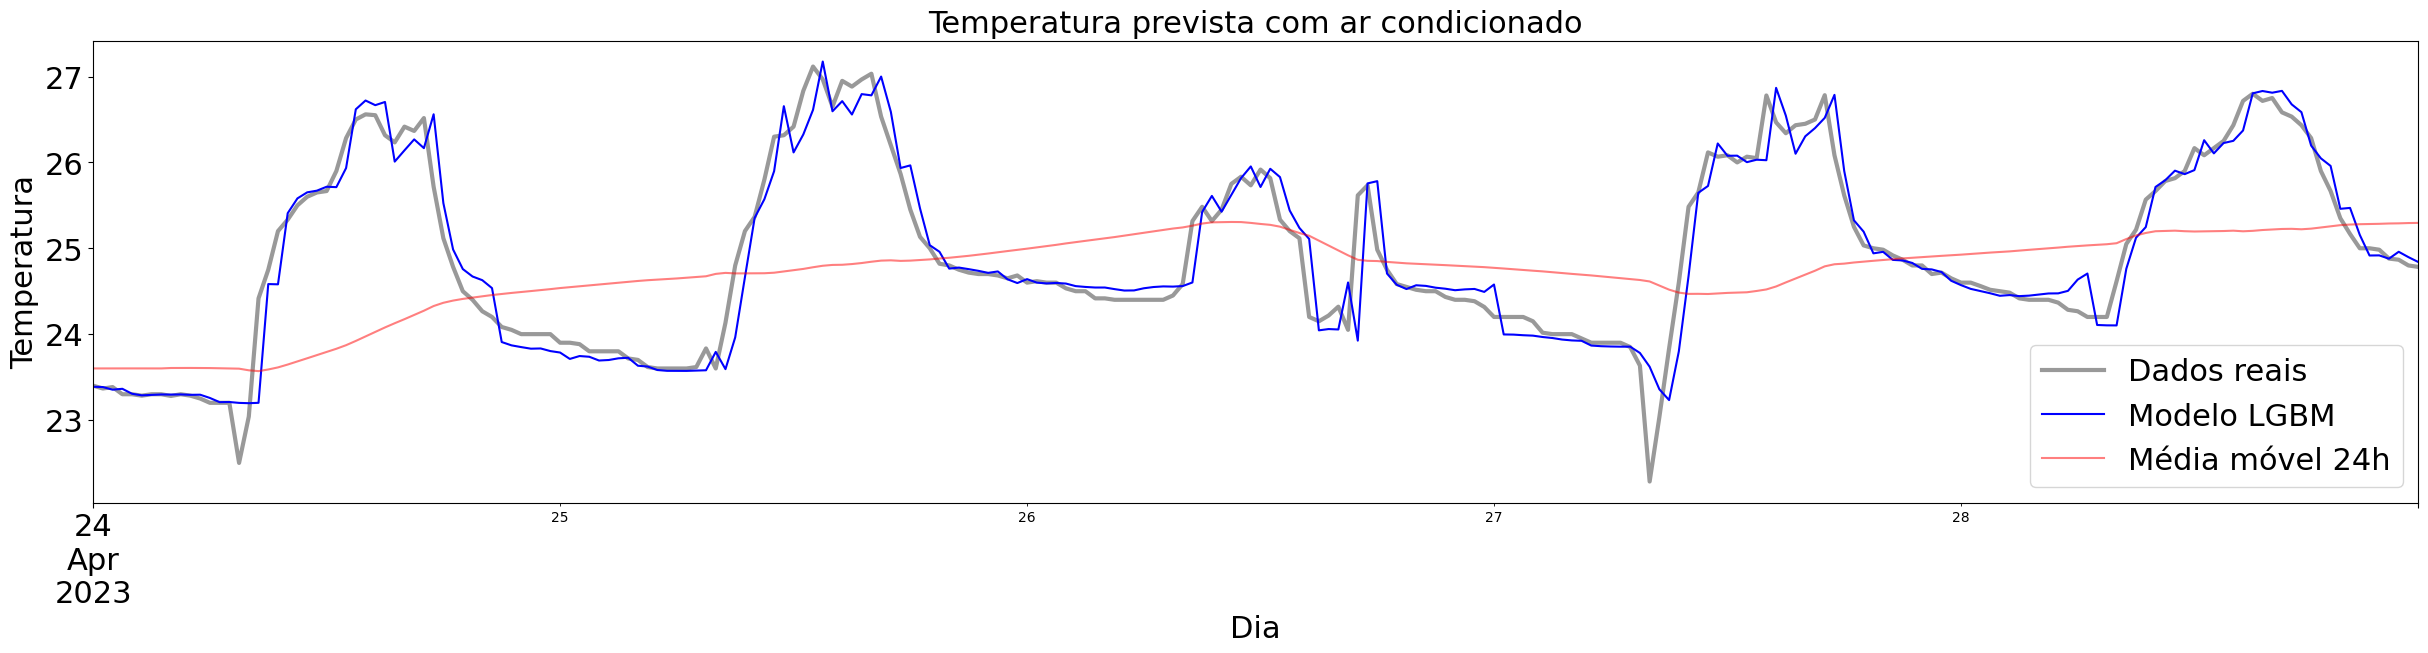

CPU times: user 754 ms, sys: 120 ms, total: 874 ms
Wall time: 753 ms


In [130]:
%%time
plt.figure(figsize=(30,6))
y_plot_comar.plot(c='grey',alpha=0.8,linewidth=3) # Dados reais
y_preds_comar.plot(c='blue') # Dados reais
y_mdmv_plot_comar.plot(c='red',alpha=0.5) # Dados reais
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dia',size=22)
plt.ylabel('Temperatura',size=22)
plt.title('Temperatura prevista com ar condicionado',size=22)
plt.legend(['Dados reais','Modelo LGBM','Média móvel 24h'],fontsize=22)
plt.savefig('temperatura_prevista_lgbm.png', facecolor='white', transparent=False) 
plt.show()

## Dados sem ar condicionado

O melhor modelo foi o RandomForestRegressor, então precisamos encontrar os melhores hiperparâmetros para esse modelo.

In [133]:
''' %%time
rcv_semar = RandomizedSearchCV(RandomForestRegressor(), param_distributions = param_grid,cv = TimeSeriesSplit(n_splits=3),
                        scoring='neg_mean_absolute_error', verbose=True, n_jobs = -1, n_iter = 100, random_state=42)
rcv_semar.fit(X_train_semar,y_train_semar) '''

" %%time\nrcv_semar = RandomizedSearchCV(RandomForestRegressor(), param_distributions = param_grid,cv = TimeSeriesSplit(n_splits=3),\n                        scoring='neg_mean_absolute_error', verbose=True, n_jobs = -1, n_iter = 100, random_state=42)\nrcv_semar.fit(X_train_semar,y_train_semar) "

In [134]:
''' melhores_parametros_semar = rcv_semar.best_params_
rcv_semar.best_params_ '''

' melhores_parametros_semar = rcv_semar.best_params_\nrcv_semar.best_params_ '

In [135]:
%%time
modelo_semar = RandomForestRegressor().fit(X_train_semar,y_train_semar)
y_pred_final_semar = pd.Series(modelo.predict(X_semar),index=X_semar.index)

CPU times: user 2.52 s, sys: 8.72 ms, total: 2.53 s
Wall time: 2.54 s


In [136]:
y_mediamovel_semar_geral = y_semar.rolling(window=48,closed='left').mean().dropna()
x_pl_semar = X_semar[(X_semar.index >= '2023-04-24 00:00:00') & (X_semar.index < '2023-04-29 00:00:00')]

y_plot_semar = y_semar[x_pl_semar.index]
y_preds_semar = y_pred_final_semar[x_pl_semar.index]
y_mdmv_plot_semar = y_mediamovel_semar_geral[x_pl_semar.index]

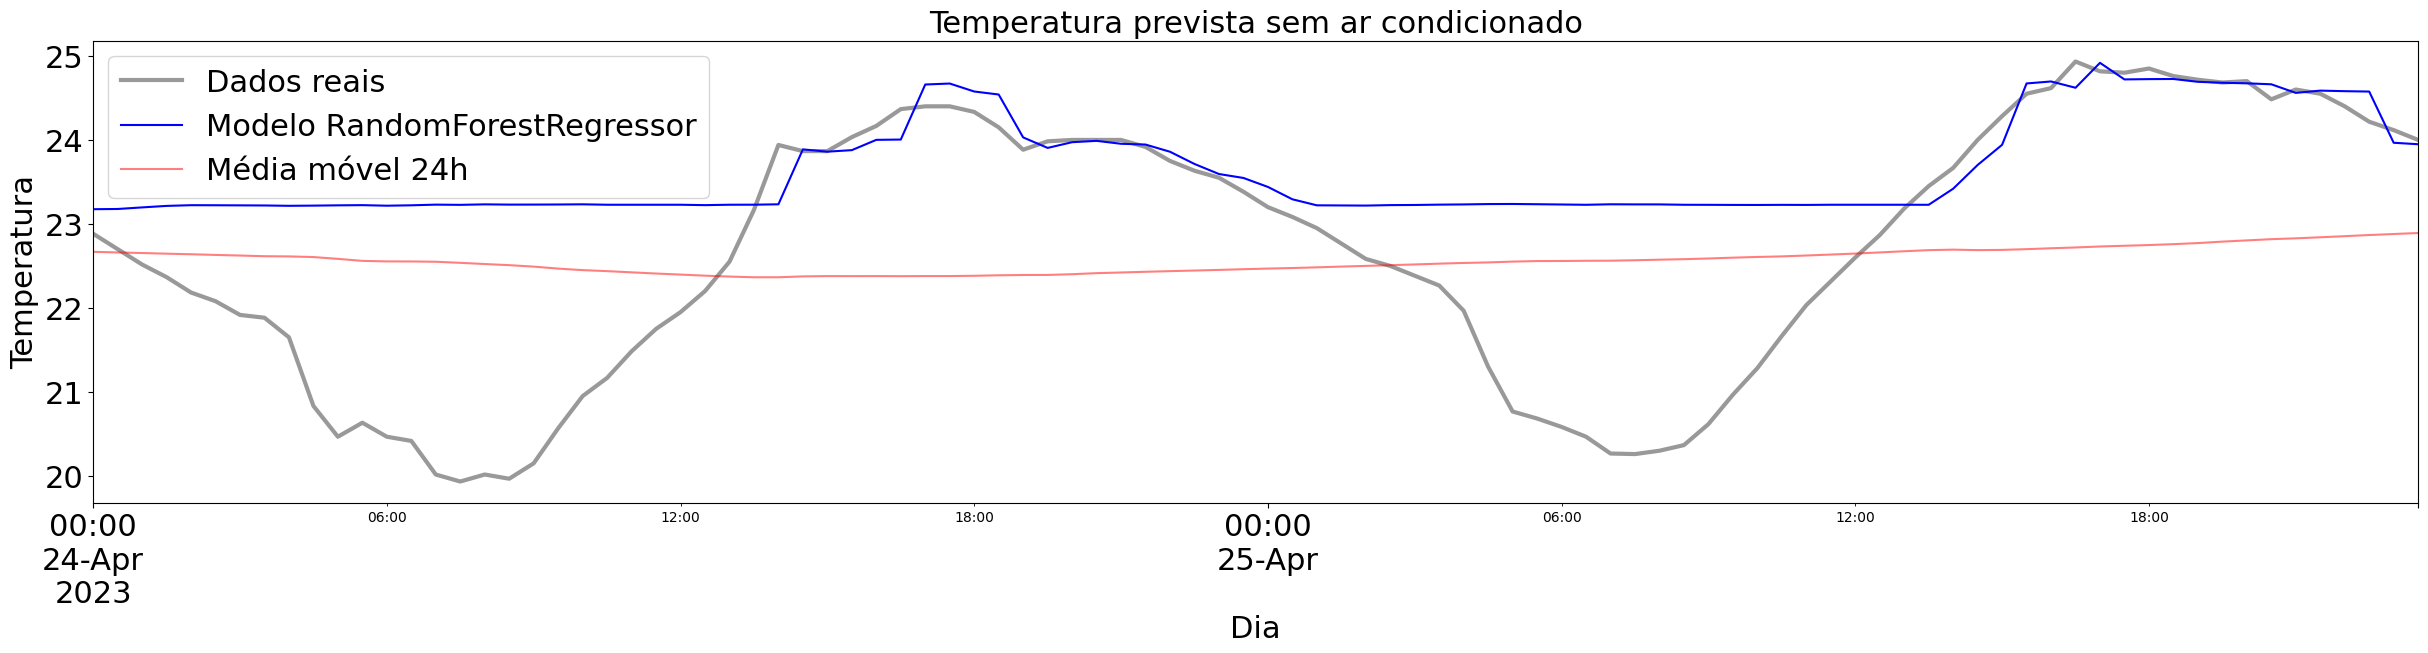

CPU times: user 763 ms, sys: 113 ms, total: 877 ms
Wall time: 798 ms


In [137]:
%%time
plt.figure(figsize=(30,6))
y_plot_semar.plot(c='grey',alpha=0.8,linewidth=3) # Dados reais
y_preds_semar.plot(c='blue') # Dados reais
y_mdmv_plot_semar.plot(c='red',alpha=0.5) # Dados reais
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dia',size=22)
plt.ylabel('Temperatura',size=22)
plt.title('Temperatura prevista sem ar condicionado',size=22)
plt.legend(['Dados reais','Modelo RandomForestRegressor','Média móvel 24h'],fontsize=22)
plt.savefig('temperatura_prevista_random_forest_regressor_semar.png', facecolor='white', transparent=False) 
plt.show()